In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.spatial import cKDTree

def get_income_data():
  income_data = pd.DataFrame({
    'Income Bracket': [
        'Less than $10,000', '$10,000 to $14,999', '$15,000 to $24,999',
        '$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to $74,999',
        '$75,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999', '$200,000 or more'],
    'Percentage': [5.3, 4.6, 7.7, 8.3, 10.4, 17.2, 13.2, 15.9, 8.1, 9.3]})
  total_households = 471767
  return income_data,total_households

def impute_missing_values(gdf, columns_to_impute='median_hh_income', k=5):
    """
    Impute missing values in the GeoDataFrame using spatial nearest neighbors with an imputed_flag column.
    """
    gdf=gdf.to_crs(epsg=32616)
    coords = np.array(list(zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y)))
    tree=cKDTree(coords)
    gdf['imputed_flag'] = 0
    for idx, row in gdf.iterrows():
        if pd.isna(row[columns_to_impute]):
            distances, indices = tree.query(coords[idx], k=k)
            valid_neighbors = gdf.iloc[indices][columns_to_impute].dropna()

            if not valid_neighbors.empty:
                imputed_values = valid_neighbors.mean()
                gdf.loc[idx, columns_to_impute] = imputed_values
                gdf.loc[idx, 'imputed_flag'] = 1
    return gdf

def calculate_income_quantiles_cbsa(total_households, income_data, cbg_gdf):
    income_data['Households'] = (income_data['Percentage'] / 100) * total_households
    income_data['Cumulative Households'] = income_data['Households'].cumsum()
    quantiles = [0, total_households * 0.25, total_households * 0.5, total_households * 0.75, total_households]
    income_data['cbsa_income_quantile'] = pd.cut(income_data['Cumulative Households'], bins=quantiles,
                                            labels=['low', 'lower_middle', 'upper_middle', 'high'], include_lowest=True)
    cbg_gdf['income_quantile'] = pd.qcut(cbg_gdf['median_hh_income'], 4, labels=['low', 'lower_middle', 'upper_middle', 'high'])

    return cbg_gdf

In [ ]:
def normalize_dict_values_to_sum_to_one_and_cast_keys_to_ints(old_dict):
    """
    Self-explanatory; used by aggregate_visitor_home_cbgs_over_months.
    """
    new_dict = {}
    value_sum = 1.*sum(old_dict.values())
    if len(old_dict) > 0:
        assert value_sum > 0
    for k in old_dict:
        new_dict[int(k)] = old_dict[k] / value_sum
    return new_dict

def cast_keys_to_ints(old_dict):
    new_dict = {}
    for k in old_dict:
        new_dict[int(k)] = old_dict[k]
    return new_dict

In [ ]:
def process_adjusted_visitors(df,column):
    df[column] = np.ceil(df[column]).astype(int)
    df = df[df[column] > 0]
    return df

def map_columns(expanded_df, cbg_gdf, columns_to_map):
    cbg_gdf['cbg'] = cbg_gdf['cbg'].astype(str).str.lstrip('0')
    expanded_df['origin_cbg'] = expanded_df['origin_cbg'].astype(str).str.lstrip('0')
    for col in columns_to_map:
        mapping_dict = cbg_gdf.set_index('cbg')[col].to_dict()
        expanded_df[col] = expanded_df.set_index('origin_cbg').index.map(mapping_dict)
    return expanded_df

def move_column(df, column_name, new_position):
    col = df.pop(column_name)
    # Insert it at the new position
    df.insert(new_position, column_name, col)
    return df

def map_poi_columns(expanded_df, mp, columns_to_map):
    for col in columns_to_map:
        mapping_dict = mp.set_index('PLACEKEY')[col].to_dict()
        expanded_df[col] = expanded_df.set_index('PLACEKEY').index.map(mapping_dict)

    return expanded_df
def remove_outliers_iqr(df, column, save_path="/content/drive/MyDrive/data/removed_outliers_v2.csv"):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    clean_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers.to_csv(save_path, index=False)
    print(f"Saved {len(outliers)} outliers to {save_path}")
    return clean_df
def filter_low_visit_counts(df_filtered):
    print("Filtering POIs with visit counts below the 25th percentile:")
    initial_row_count = df_filtered.shape[0]
    threshold = df_filtered['RAW_VISIT_COUNTS'].quantile(0.25)
    removed_rows_df = df_filtered[df_filtered['RAW_VISIT_COUNTS'] < threshold]
    df_filtered = df_filtered[df_filtered['RAW_VISIT_COUNTS'] >= threshold].reset_index(drop=True)
    final_row_count = df_filtered.shape[0]
    removed_rows = initial_row_count - final_row_count
    removed_rows_df.to_csv('/content/drive/MyDrive/data/removed_low_visit_rows_022124.csv', index=False)
    print(f"Number of rows removed after outlier filtering: {removed_rows}")
    print(f"Final number of POIs in dataset: {df_filtered['PLACEKEY'].nunique()}")
    return df_filtered

In [ ]:
def plot_footfall_by_hour(mp,col,category):
  df_tmp_1 = mp[mp[col] == category].copy()
  arr_1 = df_tmp_1['POPULARITY_BY_HOUR'].apply(lambda x: np.array(literal_eval(x))).sum()
  #arr_2 = df_tmp_2['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
  arr = arr_1#-arr_2
  arr = arr - arr[np.argmin(arr)]
  plt.bar(range(0,24), arr)
  plt.ylabel('total footfall')
  plt.xlabel('hour of the day')
  plt.title(f'total footfall at {category} in Birmingham in December 2023')
  plt.show()

def plot_dists(mp,col,bins=5):
  sns.histplot(data=mp,x=col, bins=bins, kde=True)
  plt.show()

def plot_footfall_by_day(mp,col,category):
  df_tmp_1 = mp[mp[col] == category].copy()
  arr_1 = df_tmp_1['VISITS_BY_DAY'].apply(lambda x: np.array(literal_eval(x))).sum()
  #arr_2 = df_tmp_2['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
  arr = arr_1#-arr_2
  arr = arr - arr[np.argmin(arr)]
  plt.bar(range(0,31), arr)
  plt.ylabel('total footfall')
  plt.xlabel('day of month')
  plt.title(f'total footfall at {category} in Birmingham in December 2023')
  plt.show()

def plot_seg(mp):
    """Plots violin + strip plot for income segregation across place categories."""
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=mp.dropna(subset='income_segregation'), x="place_category", y="income_segregation", palette="tab20", inner=None, alpha=0.7)
    sns.stripplot(data=mp.dropna(subset='income_segregation'), x="place_category", y="income_segregation", palette="tab20", size=4, jitter=True, alpha=0.8)
    plt.title("Distribution of income_segregation by Place Category", fontsize=14)
    plt.xlabel("Place Category")
    plt.ylabel("income_segregation")
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [ ]:
def cbg_to_str(df,column):
    df.rename(columns={column:'cbg'},inplace=True)
    df['cbg']=df['cbg'].astype(str).str.lstrip('0')
    return df

In [ ]:
def fix_malformed_dict_str(s):
    """Fixes malformed dictionary strings by ensuring they end with a closing brace."""
    if not s.endswith("}"):
        last_comma_index = s.rfind(",")
        if last_comma_index != -1:
            s = s[:last_comma_index] + "}"
    return s

def extract_valid_cbgs(visitor_home_cbgs, valid_cbgs):
    """
    Extracts home CBGs from VISITOR_HOME_CBGS, filtering out CBGs not present in valid_cbgs.
    """
    global unparsed_count
    try:
        fixed_str = fix_malformed_dict_str(visitor_home_cbgs)
        visitor_dict = json.loads(fixed_str)
        cbg_list_visitor = [(int(cbg), int(count)) for cbg, count in visitor_dict.items() if int(cbg) in valid_cbgs]
        return cbg_list_visitor
    except Exception:
        unparsed_count += 1
        return []

def adjust_for_visitor_loss(cbg_list_visitor, raw_visitor):
    """
    Adjusts for visitor loss by redistributing unknown visitors across known CBGs.
    """
    sum_known_visitors = sum([x for _, x in cbg_list_visitor])
    if sum_known_visitors == 0:
        return cbg_list_visitor
    unknown_visitors = raw_visitor - sum_known_visitors
    assigned_cbg_list_visitor = [(cbg, no + no * unknown_visitors / sum_known_visitors) for cbg, no in cbg_list_visitor]
    return assigned_cbg_list_visitor

def adjust_home_cbg_counts_for_coverage(cbg_counter, cbg_coverage, median_coverage, max_upweighting_factor=100):
    """
    Adjusts CBG counts for SafeGraph's differential sampling across CBGs.
    """
    had_to_guess_coverage_value = False
    if not cbg_counter:
        return cbg_counter, had_to_guess_coverage_value
    new_counter = Counter()
    for cbg, count in cbg_counter.items():
        if cbg not in cbg_coverage or np.isnan(cbg_coverage[cbg]):
            upweighting_factor = 1 / median_coverage
            had_to_guess_coverage_value = True
        else:
            upweighting_factor = 1 / cbg_coverage[cbg]
            if upweighting_factor > max_upweighting_factor:
                upweighting_factor = 1 / median_coverage
                had_to_guess_coverage_value = True
        new_counter[cbg] = count * upweighting_factor
    return new_counter, had_to_guess_coverage_value
def process_cbg_data_v2(df_m, cbg_gdf, raw_visitor_col, visitor_home_cbgs_col):
    global unparsed_count
    unparsed_count = 0
    cbg_gdf["cbg"] = cbg_gdf["cbg"].astype(str).str.lstrip("0").astype(int)
    valid_cbgs_set = set(cbg_gdf["cbg"])
    total_population = cbg_gdf["tot_pop"].to_numpy()
    num_devices = cbg_gdf["number_devices_residing"].to_numpy()
    cbg_coverage = num_devices / total_population
    median_coverage = np.nanmedian(cbg_coverage)
    cbg_coverage_dict = dict(zip(cbg_gdf["cbg"], cbg_coverage))

    def process_row(row):
        raw_visitor = row[raw_visitor_col]
        visitor_home_cbgs = row[visitor_home_cbgs_col]
        cbg_list_visitor = extract_valid_cbgs(visitor_home_cbgs, valid_cbgs_set)
        assigned_cbg_list_visitor = adjust_for_visitor_loss(cbg_list_visitor, raw_visitor)
        cbg_counter = Counter(dict(assigned_cbg_list_visitor))
        adjusted_cbg_counter, _ = adjust_home_cbg_counts_for_coverage(cbg_counter, cbg_coverage_dict, median_coverage)
        adjusted_cbg_counter = {cbg: count for cbg, count in adjusted_cbg_counter.items() if cbg in valid_cbgs_set}
        return adjusted_cbg_counter
    df_m["adjusted_cbg_visitors"] = df_m.apply(process_row, axis=1)
    print(f"Number of rows not able to be parsed: {unparsed_count}")

    return df_m

In [ ]:
def compute_income_segregation(df, cbg_gdf):
    """
    For each POI (i.e. each row in df), compute an income segregation score
    based on the processed visitor counts.

    The function maps each CBG (key in the processed dict) to an income quartile
    (using cbg_income_map, which should map CBG (as int) to a quartile in {1,2,3,4}),
    sums the visitor counts by quartile, and then calculates the segregation
    measure as:

         segregation = (2/3) * sum(|proportion - 0.25|)

    where the proportion is the fraction of visitors from each quartile.

    Parameters:
      df             : DataFrame that now includes 'processed_visitor_home_cbgs'
      cbg_income_map : Dictionary mapping CBG (as int) to income quartile (1-4)

    Returns:
      The DataFrame with an added column 'income_segregation'
    """
    income_label_to_quartile = {"low": 1, "lower_middle": 2, "upper_middle": 3, "high": 4}

    # Ensure CBGs in `cbg_gdf` are correctly formatted
    cbg_gdf["cbg"] = cbg_gdf["cbg"].astype(str).str.lstrip("0").astype(int)

    # Create mapping: CBG → Income Quartile
    cbg_income_map = cbg_gdf.set_index("cbg")["income_quantile"].map(income_label_to_quartile).to_dict()

    def segregation_from_dict(visitor_dict):
        """Compute the segregation score for a single POI."""
        # Array to store counts per quartile (4 income groups)
        quartile_counts = np.zeros(4, dtype=float)

        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)  # Ensure CBG is an integer
            except Exception:
                continue


    def segregation_from_dict(visitor_dict):
        # Build an array for the 4 income quartiles.
        quartile_counts = np.zeros(4, dtype=float)
        for cbg, count in visitor_dict.items():
            try:
                cbg_int = int(cbg)
            except Exception:
                continue
            quartile = cbg_income_map.get(cbg_int, None)

            if quartile is not None:
                quartile_counts[quartile - 1] += count  # Store in 0-based index

        total = quartile_counts.sum()
        if total == 0:
            return np.nan  # Avoid division by zero

        proportions = quartile_counts / total
        # Compute segregation score: (2/3) * sum(|proportion - 0.25|)
        segregation = (2/3) * np.sum(np.abs(proportions - 0.25))
        return segregation

    df['income_segregation'] = df['adjusted_cbg_visitors'].apply(segregation_from_dict)
    return df


In [ ]:
def process_pois_and_stops(mp,stops, radius=250):
    stops = stops.loc[stops['TOP_CATEGORY'] == 'Urban Transit Systems'].copy()
    stops.loc[:, 'LOCATION_NAME'] = stops['LOCATION_NAME'].str.replace(r'^Birmingham Jefferson County Transit Authority\s*', '', regex=True)
    stops.loc[:, 'geometry'] = stops.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
    stops_gdf = gpd.GeoDataFrame(stops, geometry='geometry', crs="EPSG:4326").to_crs(epsg=32616)
    mp=mp.copy()
    mp.loc[:, 'geometry'] = mp.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
    pois_gdf = gpd.GeoDataFrame(mp, geometry='geometry', crs="EPSG:4326").to_crs(epsg=32616)
    stop_coords = list(zip(stops_gdf.geometry.x, stops_gdf.geometry.y))
    poi_coords = list(zip(pois_gdf.geometry.x, pois_gdf.geometry.y))
    stop_tree = cKDTree(stop_coords)
    results = []
    for idx, poi_coord in enumerate(poi_coords):
        stop_indices = stop_tree.query_ball_point(poi_coord, radius)
        valid_distances = [np.sqrt((poi_coord[0] - stop_coords[i][0])**2 + (poi_coord[1] - stop_coords[i][1])**2) for i in stop_indices]
        valid_stop_indices = [i for i, dist in zip(stop_indices, valid_distances) if dist < radius]
        nearby_stop_names = [stops_gdf.iloc[i]['LOCATION_NAME'] for i in valid_stop_indices]
        #nearby_stop_ids = [stops_gdf.iloc[i]['stop_id'] for i in valid_stop_indices]
        results.append({
            'PLACEKEY': pois_gdf.iloc[idx]['PLACEKEY'],
            'nearby_stops': nearby_stop_names,
            #'nearby_stop_ids':nearby_stop_ids,
            'nearby_stop_distances': valid_distances})
    nearby_pois = pd.DataFrame(results)
    nearby_pois = nearby_pois[(nearby_pois['nearby_stops'].apply(lambda x: len(x) > 0)) &
                              (nearby_pois['nearby_stop_distances'].apply(lambda x: len(x) > 0))].reset_index(drop=True)
    mp = mp.merge(nearby_pois, on="PLACEKEY", how="left")
    mp.loc[:, 'nearby_stops'] = mp['nearby_stops'].fillna('[]').apply(lambda x: literal_eval(x) if isinstance(x, str) else x)
    mp.loc[:, 'nearby_stop_distances'] = mp['nearby_stop_distances'].fillna('[]')
    mp.loc[:, 'num_nearby_stops'] = mp['nearby_stops'].apply(len)
    mp.drop_duplicates(subset="PLACEKEY", inplace=True, ignore_index=True)
    mp.dropna(subset="PLACEKEY", inplace=True, ignore_index=True)
    return mp

In [ ]:
def save_mp(mp):
  mp.to_csv('/content/drive/MyDrive/data/mp_v2.csv',index=False)

In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from collections import Counter
from shapely.geometry import Polygon,Point
import json
from shapely.wkt import loads
pd.set_option('display.max_columns', None)
import geopandas as gpd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz
from scipy.spatial import cKDTree
import ast
from ast import literal_eval
SUB_CATEGORY_MAPPING={'Restaurants':['Full-Service Restaurants','Casino Hotels','Limited-Service Restaurants'],
                      'Coffee Shops, Snacks & Bakeries':['Snack and Nonalcoholic Beverage Bars','Bakeries and Tortilla Manufacturing','Confectionery and Nut Stores','Baked Goods Stores'],
                      'Retail for Basic Necessities': ['All Other Health and Personal Care Stores','All Other Specialty Food Stores','Meat Markets','Fruit and Vegetable Markets','Fish and Seafood Markets',
                                                       'Supermarkets and Other Grocery (except Convenience) Stores','Gasoline Stations',
                                                       'Pharmacies and Drug Stores','Optical Goods Stores','Warehouse Clubs and Supercenters','Department Stores','Fuel Dealers','General Merchandise Stores, including Warehouse Clubs and Supercenters','All Other General Merchandise Stores'],
                      'Sports and Exercise':['Motorcycle, Bicycle, and Parts Manufacturing','Fitness and Recreational Sports Centers','Golf Courses and Country Clubs','Racetracks',],
                      'Healthcare':['General Medical and Surgical Hospitals','Offices of Other Health Practitioners', 'Offices of Mental Health Practitioners (except Physicians)',
                                  'Offices of Physicians','Blood and Organ Banks','Outpatient Care Centers','Offices of Physicians (except Mental Health Specialists)',
                                  'Offices of Dentists','Specialty (except Psychiatric and Substance Abuse) Hospitals','Medical and Diagnostic Laboratories',
                                  'Other Ambulatory Health Care Services'],
                      'Social Support':['Psychiatric and Substance Abuse Hospitals','Nursing Care Facilities (Skilled Nursing Facilities)','Other Information Services','Child Day Care Services',
                                     'Nursing and Residential Care Facilities','Community Food Services','Community Food and Housing, and Emergency and Other Relief Services',
                                     'Continuing Care Retirement Communities and Assisted Living Facilities for the Elderly', 'Home Health Care Services',
                                     'Individual and Family Services', 'Services for the Elderly and Persons with Disabilities','Administration of Public Health Programs.',
                                     'Social Assistance', 'Outpatient Mental Health and Substance Abuse Centers', 'Child and Youth Services',
                                     'Administration of Housing Programs, Urban Planning, and Community Development','Administration of Human Resource Programs'],
                      'Religious Organizations': ['Religious Organizations'],
                      'School':['Sports and Recreation Instruction','Elementary and Secondary Schools','Other Schools and Instruction','All Other Amusement and Recreation Industries'],
                      'Financial, Legal, Real Estate and Insurance Services':['Tax Preparation Services','Other Accounting Services','Financial Advice','Consumer Lending','Investment Advice','Accounting, Tax Preparation, Bookkeeping, and Payroll Services','Miscellaneous Financial Investment Activities','Credit Unions','All Other Nondepository Credit Intermediation','Other Activities Related to Credit Intermediation','Offices of Notaries','Commercial Banking','Offices of Lawyers','Insurance Agencies and Brokerages','Direct Life Insurance Carriers',
                                                                                'Other Direct Insurance (except Life, Health, and Medical) Carriers','Mortgage and Nonmortgage Loan Brokers','Tax Preparation Services','Other Accounting Services','Offices of Real Estate Agents and Brokers','Residential Property Managers'],
                      'City/Outdoors':['Cemeteries and Crematories','Justice, Public Order, and Safety Activities','RV (Recreational Vehicle) Parks and Recreational Camps','Nature Parks and Other Similar Institutions',
                                    'Executive, Legislative, and Other General Government Support','Administration of Economic Programs','Business Associations','Civic and Social Organizations','Courts','Fire Protection','Other Social Advocacy Organizations','Regulation and Administration of Transportation Programs','Police Protection','Cemeteries and Crematories','Correctional Institutions','Other General Government Support',
                                    'Civic and Social Organizations','Social Advocacy Organizations','Civic, Social, and Fraternal Associations','Grantmaking and Giving Services'],
                      'College':['Colleges, Universities, and Professional Schools','Junior Colleges','Technical and Trade Schools'],
                      'Arts and Culture':['Sound Recording Studios','Dance Companies','Photography Studios, Portrait','Motion Picture and Video Industries',
                                          'Scenic and Sightseeing Transportation','Zoos and Botanical Gardens','Art Dealers','Sound Recording Industries','Theater Companies and Dinner Theaters',
                                          'Radio and Television Broadcasting','Museums','Historical Sites','Performing Arts Companies'],
                      'Entertainment':['Promoters of Performing Arts, Sports, and Similar Events with Facilities','Motion Picture Theaters (except Drive-Ins)','Bowling Centers','Wineries','Amusement Parks and Arcades','Beverage Manufacturing',
                                    'Spectator Sports','Other Amusement and Recreation Industries','Casinos (except Casino Hotels)', 'Other Gambling Industries','Drinking Places (Alcoholic Beverages)'],
                      'Discretionary Retail':['General Rental Centers','Appliance Repair and Maintenance','Lawn and Garden Equipment and Supplies Stores','Home Furnishings Stores','Home Furnishings', 'Other Clothing Stores','Food (Health) Supplement Stores',
                                            'Used Merchandise Stores', 'Book Stores',
                                            'Cosmetics, Beauty Supplies, and Perfume Stores','Sporting Goods Stores', 'Family Clothing Stores',"Women's Clothing Stores",
                                            'All Other Miscellaneous Store Retailers (except Tobacco Stores)','Hobby, Toy, and Game Stores','Recreational Goods Rental','Video Tape and Disc Rental','Malls','Shopping Centers',
                                            'Photofinishing Laboratories (except One-Hour)','Automobile Dealers','Other Motor Vehicle Dealers','Automotive Parts and Accessories Stores','Automotive Equipment Rental and Leasing',
                                              'Automotive Parts, Accessories, and Tire Stores','Automotive Repair and Maintenance','Convenience Stores','Furniture Stores','Tobacco Stores', 'Beer, Wine, and Liquor Stores',
                                            'Sewing, Needlework, and Piece Goods Stores','Clothing Stores','Gift, Novelty, and Souvenir Stores', 'Electronics Stores','Jewelry Stores', 'Shoe Stores', 'Pet and Pet Supplies Stores',
                                            'All Other Home Furnishings Stores', 'Office Supplies and Stationery Stores', 'Floor Covering Stores','Musical Instrument and Supplies Stores',
                                              'Luggage and Leather Goods Stores',"Children's and Infants' Clothing Stores",
                                            'Nursery, Garden Center, and Farm Supply Stores','Household Appliance Stores', 'Clothing Accessories Stores', "Men's Clothing Stores",
                                            'Building Material and Supplies Dealers','Wired and Wireless Telecommunications Carriers','Other Wood Product Manufacturing'],
                      'Personal Services':['Photographic Services','Travel Arrangement and Reservation Services','Veterinary Services','Lessors of Miniwarehouses and Self-Storage Units','Consumer Goods Rental',
                                           'Offices of All Other Miscellaneous Health Practitioners','Death Care Services','Funeral Homes and Funeral Services',
                                        'Other Personal Services','Personal Care Services','Couriers and Express Delivery Services','Specialized Design Services',
                                        'Florists','Employment Services','Personal and Household Goods Repair and Maintenance',
                                        'All Other Consumer Goods Rental','Special Food Services','Drycleaning and Laundry Services',
                                           'Printing and Related Support Activities','Postal Service','Hotels (except Casino Hotels) and Motels','Electronic and Precision Equipment Repair and Maintenance'],
                   'Transportation':['Charter Bus Industry','Other Support Activities for Air Transportation',
                                     'Interurban and Rural Bus Transportation','Port and Harbor Operations',
                                     'Bus Rental','Other Transit and Ground Passenger Transportation','Taxi and Limousine Service','Passenger Car Rental','Motor Vehicle Towing','Parking Lots and Garages',
                                     'Transit and Ground Passenger Transportation','Urban Transit Systems','Rail Transportation'],
                      'College':['Colleges, Universities, and Professional Schools','Junior Colleges','Technical and Trade Schools'],
'Work':['Services to Buildings and Dwellings','Management, Scientific, and Technical Consulting Services','Management of Companies and Enterprises','Architectural Services','Advertising, Public Relations, and Related Services','Other Support Services','Newspaper, Periodical, Book, and Directory Publishers','Offices of Other Holding Companies','Lessors of Residential Buildings and Dwellings',
                      'Office Park','Lessors of Nonresidential Buildings (except Miniwarehouses)', 'Corporate, Subsidiary, and Regional Managing Offices','Lessors of Other Real Estate Property','Administrative Management and General Management Consulting Services','Newspaper, Periodical, Book, and Directory Publishers',
                      'Lessors of Nonresidential Buildings (except Miniwarehouses','Architectural, Engineering, and Related Services','Other Services to Buildings and Dwellings']}

sub_categories_to_pretty_names={'Restaurants':{'Fast Food':['Limited-Service Restaurants'],
                                               'Restaurants':['Full Service Restaurants','Casino Hotels']},
                              'Sports and Exercise':{'Sports Complex':['Promoters of Performing Arts, Sports, and Similar Events with Facilities'],
                                                       'Golf Courses and Country Clubs':['Golf Courses and Country Clubs'],
                                                       'Racetracks':['Racetracks'],
                                                        'Gyms and Fitness Centers': ['Motorcycle, Bicycle, and Parts Manufacturing','Fitness and Recreational Sports Centers']},
                                'Coffee Shops, Snacks & Bakeries':{'Coffee Shop':['Starbucks',"Ohenry's Coffees", 'Costa Coffee','Revelator Coffee'],
                                                                   'Donuts':["Dunkin'",'Krispy Kreme Doughnuts','Shipley Donuts','Daylight Donuts'],
                                                                   'Bakery':['Cinnaholic','Insomnia Cookies','Great American Cookies''Nothing Bundt Cakes'],
                                                                   'Ice Cream & Frozen Yogurt':['Cold Stone Creamery', "Freddy's Frozen Custard",'Yogurt Mountain', 'Baskin Robbins', 'TCBY', 'Orange Julius',
                                                                                     'Marble Slab Creamery',"Bruster's Ice Cream",],
                                                                   'Smoothie & Juice Bar':['Tropical Smoothie Café','Clean Juice','Jamba','Planet Smoothie']},
                                'Entertainment':{'Movie Theater':['Motion Picture Theaters (except Drive-Ins)'],
                                                 'Sports Stadium':['Sports Teams and Clubs','Other Spectator Sports'],
                                                 'Entertainment Venue':['Promoters of Performing Arts, Sports, and Similar Events with Facilities'],
                                                 'Bars':['Drinking Places (Alcoholic Beverages)'],
                                                 'Bowling Alley':['Bowling Centers'],
                                                 'Amusement Parks':['Amusement and Theme Parks'],
                                                 'Brewery':['Breweries','Wineries'],
                                                 'Casino':['Casinos (except Casino Hotels)'],
                                                 'Arcade':['Amusement Arcades']},
                                'Work':{'Workplace':['Services to Buildings and Dwellings',
                                        'Management, Scientific, and Technical Consulting Services',
                                        'Advertising, Public Relations, and Related Services',
                                        'Architectural, Engineering, and Related Services',
                                        'Corporate, Subsidiary, and Regional Managing Offices',
                                        'Offices of Other Holding Companies',
                                        'Newspaper, Periodical, Book, and Directory Publishers',
                                        'Janitorial Services', 'Architectural Services',
                                        'Lessors of Nonresidential Buildings (except Miniwarehouses)',
                                        'Other Support Services',
                                        'Other Services to Buildings and Dwellings']},
                                'Arts and Culture':{'Art Gallery':['Art Dealers'],
                                                    'Fine Arts Schools':['Fine Arts Schools'],
                                                    'TV Station':['Radio and Television Broadcasting'],
                                                    'Historical Landmarks':['Historical Sites'],
                                                    'Museum':['Museums'],
                                                    'Dance Company':['Dance Companies'],
                                                    'Theater':['Theater Companies and Dinner Theaters'],
                                                    'Recording Studio':['Sound Recording Studios'],
                                                    'Botanical Garden':['Zoos and Botanical Gardens'],
                                                    "Movie Production Studio":['Motion Picture and Video Production']},
                                'Transportation':{'Parking Lots and Garages':['Parking Lots and Garages'],
                                                  'Intercity Bus':['Interurban and Rural Bus Transportation'],
                                                  'Charter Bus':['Charter Bus Industry'],
                                                  'Car Rental':['Passenger Car Rental'],
                                                  'Marina':['Port and Harbor Operations'],
                                                  'Airport Shuttle':['All Other Transit and Ground Passenger Transportation','Transit and Ground Passenger Transportation','Other Support Activities for Air Transportation'],
                                                  'Towing Company':['Motor Vehicle Towing'],
                                                  'Taxi & Limo':['Limousine Service','Taxi Service']},
                                'College':{'University':['Colleges, Universities, and Professional Schools'],
                                            'Community College':['Junior Colleges'],
                                            'Trade School':['Technical and Trade Schools'],
                                            'Cosmetology School':['Cosmetology and Barber Schools']},
                                'Retail for Basic Necessities':{'Grocery Store':['Supermarkets and Other Grocery (except Convenience) Stores'],
                                                                 'Fresh Food Market':['Fish and Seafood Markets', 'Fruit and Vegetable Markets','Meat Markets', 'All Other Specialty Food Stores'],
                                                                'Optical Goods Stores':['Optical Goods Stores'],
                                                                'Warehouse Clubs and Supercenters':['Warehouse Clubs and Supercenters','All Other General Merchandise Stores'],
                                                                'Gasoline Stations':['Gasoline Stations with Convenience Stores','Fuel Dealers'],
                                                                'Department Stores':['Department Stores'],
                                                                'Pharmacy':['Pharmacies and Drug Stores'],
                                                                'Medical Aids Store':['All Other Health and Personal Care Stores']},
                                'Personal Services':{'Beauty Salon':['Beauty Salons'],
                                                     'Nail Salon':['Nail Salons'],
                                                     'Spa':['Other Personal Care Services','Hair, Nail, and Skin Care Services','Personal Care Services', 'Other Personal Services'],
                                                     'Hotel':['Hotels (except Casino Hotels) and Motels'],
                                                     'Florist':['Florists'],
                                                     'Barber Shops':['Barber Shops'],
                                                     'Drycleaners':['Drycleaning and Laundry Services (except Coin-Operated)'],
                                                     'Event Center':['All Other Consumer Goods Rental'],
                                                     'Caterers':['Caterers'],
                                                     'Veterinarian':['Veterinary Services'],
                                                     'Electronics Repair':['Consumer Electronics Repair and Maintenance'],
                                                     'Household Goods Repair':['Home and Garden Equipment Repair and Maintenance','Reupholstery and Furniture Repair','Other Personal and Household Goods Repair and Maintenance','Footwear and Leather Goods Repair'],
                                                     'Post Office':['Postal Service'],
                                                     'Employment Placement Agency':['Temporary Help Services','Employment Placement Agencies'],
                                                     'Pet Care':['Pet Care (except Veterinary) Services'],
                                                     'Travel Agency':['Travel Arrangement and Reservation Services'],
                                                     'Graphic Designer':['Specialized Design Services'],
                                                     'Weight Loss Center':['Diet and Weight Reducing Centers'],
                                                     'Print & Ship Center':['Couriers and Express Delivery Services','Printing and Related Support Activities','Commercial Screen Printing'],
                                                     'Alternative Medicine':['Offices of All Other Miscellaneous Health Practitioners'],
                                                     'Photographer':['Photographic Services'],
                                                     'Storage Unit':['Lessors of Miniwarehouses and Self-Storage Units'],
                                                     'Funeral Home':['Death Care Services','Funeral Homes and Funeral Services']},
                                'Discretionary Retail':{'Mall':['Malls'],
                                                        'Shopping Center':['Shopping Centers'],
                                                        'Auto Body Shop':['All Other Automotive Repair and Maintenance','General Automotive Repair','Automotive Body, Paint, and Interior Repair and Maintenance','Automotive Glass Replacement Shops',
                                                                          'Automotive Transmission Repair','Other Automotive Mechanical and Electrical Repair and Maintenance'],
                                                        'Photo Prints Center':['Photofinishing Laboratories (except One-Hour)'],
                                                        'Convenience Store': ['Convenience Stores'],
                                                        'Hardware Store':['Hardware Stores'],
                                                        'Sporting Goods and Outdoor Gear':['Sporting Goods Stores'],
                                                        'Clothing Accessories Stores':['Clothing Accessories Stores'],
                                                        'Car Dealership':['New Car Dealers','Automobile Dealers','Used Car Dealers'],
                                                        'Car Parts Store':['Automotive Parts and Accessories Stores'],
                                                        'Tire Shop':['Tire Dealers'],
                                                        'Women\'s Clothing Store':["Women's Clothing Stores"],
                                                        'Men\'s Clothing Store':["Men's Clothing Stores",'Clothing Stores'],
                                                        'Shoe Store':['Shoe Stores'],
                                                        'Video Rental Store':['Video Tape and Disc Rental'],
                                                        'Arts & Crafts Store':['Sewing, Needlework, and Piece Goods Stores'],
                                                        'Farm and Garden Store':['Lawn and Garden Equipment and Supplies Stores','Nursery, Garden Center, and Farm Supply Stores'],
                                                        'Family and Children\'s Clothing Store':["Family Clothing Stores","Children's and Infants' Clothing Stores"],
                                                        'Other Motor Vehicle Dealers':['Boat Dealers','Motorcycle, ATV, and All Other Motor Vehicle Dealers','Truck, Utility Trailer, and RV (Recreational Vehicle) Rental and Leasing'],
                                                        'Car Wash':['Car Washes'],
                                                        'Used Merchandise Store':['Used Merchandise Stores'],
                                                        'Office Supplies and Stationery Store':['Office Supplies and Stationery Stores'],
                                                        'Bookstore':['Book Stores and News Dealers'],
                                                        'Furniture and Home Decor Store':['Floor Covering Stores','Home Furnishings Stores','Furniture Stores','All Other Home Furnishings Stores'],
                                                        'Jewelry Store':['Jewelry Stores'],
                                                        'Luggage, and Leather Goods Stores':['Luggage, and Leather Goods Stores','Luggage and Leather Goods Stores'],
                                                        'Gift & Souvenir Shop':['Gift, Novelty, and Souvenir Stores'],
                                                        'Pet Supply Store':['Pet and Pet Supplies Stores'],
                                                        'Cell Phone Provider':['Wired and Wireless Telecommunications Carriers'],
                                                        'Hobby, Toy, and Game Store':['Hobby, Toy, and Game Stores'],
                                                        'Home Improvement Store':['Building Material and Supplies Dealers','Other Building Material Dealers','Home Centers','Paint and Wallpaper Stores','Other Wood Product Manufacturing'],
                                                        'Household Appliance Store':['Household Appliance Stores','Appliance Repair and Maintenance'],
                                                        'Cosmetics/Fragrance Store':['Cosmetics, Beauty Supplies, and Perfume Stores'],
                                                        'Health Supplement Store':['Food (Health) Supplement Stores'],
                                                        'Smoke Shop':['Tobacco Stores'],
                                                        'Rental':['General Rental Centers','All Other Consumer Goods Rental'],
                                                        'Liquor Store':['Beer, Wine, and Liquor Stores'],
                                                        'Other Miscellaneous Store Retailers':['All Other Miscellaneous Store Retailers (except Tobacco Stores)']},
                                'Financial, Legal, Real Estate and Insurance Services':{'Real Estate Agents':['Offices of Real Estate Agents and Brokers','Residential Property Managers'],
                                                            'Mortgage Brokers':['Mortgage and Nonmortgage Loan Brokers'],
                                                            'Insurance Agency':['Insurance Agencies and Brokerages','Direct Life Insurance Carriers',
                                                                                'Other Direct Insurance (except Life, Health, and Medical) Carriers'],
                                                            'Lawyers':['Offices of Lawyers'],
                                                            'Bank':['Commercial Banking'],
                                                            'Notary':['Offices of Notaries'],
                                                            'Credit Unions':['Credit Unions','All Other Nondepository Credit Intermediation','Other Activities Related to Credit Intermediation',],
                                                            'Financial Advisors':['Financial Advice','Investment Advice','Miscellaneous Financial Investment Activities'],
                                                            'Consumer Lending':['Consumer Lending'],
                                                            'Accoutants':['Tax Preparation Services','Other Accounting Services']},
                                'Healthcare':{'Physical Therapist':['Offices of Physical, Occupational and Speech Therapists, and Audiologists'],
                                              'Kidney Dialysis Center':['Kidney Dialysis Centers'],'Medical Laboratories':['Medical Laboratories'],
                                              'Family Planning Center':['Family Planning Centers'],'Blood Bank':['Blood and Organ Banks'],
                                              'Psychiatrist\'s Office':['Offices of Physicians, Mental Health Specialists','Offices of Physicians, Mental Health Specialists'],
                                              'Dentist\'s Office':['Offices of Dentists','Teeth Whitening'],
                                              'Doctor\'s Office':['Offices of Physicians (except Mental Health Specialists)','Specialty (except Psychiatric and Substance Abuse) Hospitals'],
                                              'Hospital':['General Medical and Surgical Hospitals',],
                                              'Therapist':['Offices of Mental Health Practitioners (except Physicians)'],
                                              'Urgent Care':['Freestanding Ambulatory Surgical and Emergency Centers','Urgent Care','Urgent Care,Walk-in Clinic'],
                                              'Psychiatric and Substance Abuse Hospital':['Psychiatric and Substance Abuse Hospitals','Addiction Treatment'],
                                              'Optometrist':['Offices of Optometrists'],
                                              'Speech Therapist':['Speech Therapist'],
                                              'Sleep Clinic':['All Other Outpatient Care Centers'],
                                              'Chiropractor\'s Office':['Offices of Chiropractors']},
                                'Religious Organizations':{'Church':['Churches'],
                                                            'Mosque':['Mosque'],
                                                            'Buddhist Temple':['Buddhist'],
                                                            'Hindu Temple':['Hindu Temple'],
                                                            'Church Daycare':['Child Care']},
                                'Social Support':{'Home Health Care':['Home Health Care Services'],
                                                  'Community Housing Services':['Community Housing Services'],
                                                  'Daycare Center':['Child Day Care Services','Child Care'],
                                                  'Disability Services':['Services for the Elderly and Persons with Disabilities'],
                                                  'Library':['Libraries and Archives'],
                                                  'Community Center':['Other Individual and Family Services'],
                                                  'Social Security Office':['Administration of Human Resource Programs (except Education, Public Health, and Veterans Affairs Programs)'],
                                                  'Nursing Care Facility':['Nursing Care Facilities (Skilled Nursing Facilities)'],
                                                  'Child and Youth Services':['Child and Youth Services'],
                                                  'Assisted Living Facilities for the Elderly':['Assisted Living Facilities for the Elderly'],
                                                  'Substance Abuse Treatment Center':['Outpatient Mental Health and Substance Abuse Centers','New Season'],
                                                  'Temporary Shelters':['Temporary Shelters'],
                                                  'Food Bank':['Community Food Services']},
                                'School':{'Exam Prep & Tutoring Center':['Exam Preparation and Tutoring',],
                                          'Sports and Recreation Instruction':['Sports and Recreation Instruction'],
                                          'English Language Schools':['Language Schools'],
                                          'Dance School':['Fine Arts Schools'],
                                          'School':['Elementary and Secondary Schools'],
                                          'CPR & First Aid Classes':['All Other Miscellaneous Schools and Instruction'],
                                          'Summer Camp':['Summer Camp'],
                                          'Driving School':['Automobile Driving Schools'],
                                          'Art Classes':['Art Classes','Painting with a Twist']},
                                'City/Outdoors':{'Prison':['Correctional Institutions','Other General Government Support'],
                                                'Cemetery':['Cemeteries and Crematories'],
                                                'Police Station':['Police Protection'],
                                                'DMV':['Regulation and Administration of Transportation Programs',],
                                                'Fire Station':['Fire Protection',],
                                                'Rotary Club':['Other Social Advocacy Organizations'],
                                                'Courthouse':['Courts'],
                                                'Park':['Nature Parks and Other Similar Institutions'],
                                                'Social Organization':['Civic and Social Organizations'],
                                                'Chamber of Commerce':['Business Associations'],
                                                'Nonprofit':['Voluntary Health Organizations']}}
def remove_nearby_duplicate_offices(mp_gdf, placekeys_to_drop_path, distance_threshold=50, fuzz_threshold=65):
    try:
        placekeys_to_drop = pd.read_csv(placekeys_to_drop_path)
    except FileNotFoundError:
        placekeys_to_drop = pd.DataFrame(columns=['PLACEKEY'])
    excluded_brands = {'Walmart', 'Winn Dixie', 'Walgreens', 'CVS','Publix'}
    excluded_categories = {'Child Day Care Services', 'Elementary and Secondary Schools','Child and Youth Services'}
    mp_filtered = mp_gdf[(~mp_gdf['BRANDS'].isin(excluded_brands)) &(~mp_gdf['LOCATION_NAME'].str.contains("Emergency", case=False, na=False)) &(~mp_gdf['LOCATION_NAME'].str.contains("Walmart|Winn Dixie|Walgreens|CVS|Publix", case=False, na=False)) &(~mp_gdf['TOP_CATEGORY'].isin(excluded_categories))].copy()
    mp_filtered = gpd.GeoDataFrame(mp_filtered.copy(), geometry=gpd.points_from_xy(mp_filtered.LONGITUDE, mp_filtered.LATITUDE), crs="EPSG:4326").to_crs(epsg=32616)
    mp_filtered=mp_filtered[mp_filtered['POLYGON_CLASS']=='SHARED_POLYGON']
    mp_filtered = mp_filtered.reset_index(drop=True)
    coords = np.array(list(zip(mp_filtered.geometry.x, mp_filtered.geometry.y)))
    tree = cKDTree(coords)
    to_remove = set()
    new_removed_rows = []
    new_placekeys_to_drop = []
    index_mapping = dict(zip(range(len(mp_filtered)), mp_filtered.index))
    for idx, coord in zip(mp_filtered.index, coords):
        if idx in to_remove:
            continue
        nearby_indices = [mp_filtered.index[i] for i in tree.query_ball_point(coord, distance_threshold)]
        current_name = mp_filtered.at[idx, 'LOCATION_NAME']
        current_address = mp_filtered.at[idx, 'address']

        duplicates = [idx]
        for i in nearby_indices:
            if i == idx or i in to_remove:
                continue

            nearby_name = mp_filtered.at[i, 'LOCATION_NAME']
            nearby_address = mp_filtered.at[i, 'address']

            name_similarity = fuzz.ratio(current_name, nearby_name)
            address_similarity = fuzz.ratio(current_address, nearby_address)

            if name_similarity >= fuzz_threshold and address_similarity >= fuzz_threshold:
                duplicates.append(i)

        if len(duplicates) > 1:
            duplicate_rows = mp_filtered.loc[duplicates]

            parent_rows = duplicate_rows[duplicate_rows['parent_flag'] == 1]

            if not parent_rows.empty:
                # Keep one of the parent_flag=1 rows with the highest visit count
                keep_idx = parent_rows['RAW_VISIT_COUNTS'].idxmax()
            else:
                # No parent_flag=1, so keep the row with the highest visit count
                keep_idx = duplicate_rows['RAW_VISIT_COUNTS'].idxmax()

            remove_idxs = [i for i in duplicates if i != keep_idx]

            # Handle case where neither removal condition is met (same visit counts & parent flags)
            if all(mp_filtered.loc[i, 'parent_flag'] == mp_filtered.loc[keep_idx, 'parent_flag'] for i in remove_idxs) and \
               all(mp_filtered.loc[i, 'RAW_VISIT_COUNTS'] == mp_filtered.loc[keep_idx, 'RAW_VISIT_COUNTS'] for i in remove_idxs):
                remove_idxs = remove_idxs[:1]

            # If both have parent_flag=1, update PARENT_PLACEKEY references
            if len(parent_rows) > 1:
                kept_placekey = mp_filtered.loc[keep_idx, 'PLACEKEY']
                for remove_idx in remove_idxs:
                    removed_placekey = mp_filtered.loc[remove_idx, 'PLACEKEY']
                    mp_gdf.loc[mp_gdf['PARENT_PLACEKEY'] == removed_placekey, 'PARENT_PLACEKEY'] = kept_placekey
                    print(f"**Updated PARENT_PLACEKEY:** Replaced {removed_placekey} → {kept_placekey}")

            print(f"\n**Keeping:** {mp_filtered.loc[keep_idx, 'PLACEKEY']} | {mp_filtered.loc[keep_idx, 'LOCATION_NAME']} | {mp_filtered.loc[keep_idx, 'address']}")
            print("**Removing:**")
            for i in remove_idxs:
                print(f"   - {mp_filtered.loc[i, 'PLACEKEY']} | {mp_filtered.loc[i, 'LOCATION_NAME']} | {mp_filtered.loc[i, 'address']} (Matched)")

            new_removed_rows.extend(mp_filtered.loc[remove_idxs].to_dict('records'))
            new_placekeys_to_drop.extend(mp_filtered.loc[remove_idxs, 'PLACEKEY'].tolist())
            to_remove.update(remove_idxs)

    new_removed_df = pd.DataFrame(new_removed_rows)
    mp_gdf_cleaned = mp_gdf.drop(index=mp_gdf.index.intersection(to_remove)).reset_index(drop=True)
    new_placekeys_df = pd.DataFrame({'PLACEKEY': new_placekeys_to_drop})
    placekeys_to_drop = pd.concat([placekeys_to_drop, new_placekeys_df], ignore_index=True).drop_duplicates()
    placekeys_to_drop.to_csv(placekeys_to_drop_path, index=False)
    print(f"\nAdded {len(new_placekeys_to_drop)} PLACEKEYs to `{placekeys_to_drop_path}`.")
    return mp_gdf_cleaned

def calculate_polygon_diameter(mp):
    diameters = []

    for geom in mp['POLYGON_WKT']:
        try:
            # Only apply loads() if it's still a string
            if isinstance(geom, str):
                polygon = loads(geom)  # Convert WKT string to Polygon
            else:# isinstance(geom, Polygon):
                polygon = geom  # Already a Polygon, no need to convert
            #else:
                #raise ValueError("Invalid data type for POLYGON_WKT")

            # Get bounding box (min_x, min_y, max_x, max_y)
            min_x, min_y, max_x, max_y = polygon.bounds

            # Compute geodesic distance between diagonal corners
            diameter = geodesic((min_y, min_x), (max_y, max_x)).meters
            diameters.append(diameter)

        except Exception as e:
            #print(f"Error processing geometry: {geom}, Error: {e}")
            diameters.append(None)

    mp['POLYGON_DIAMETER'] = diameters
    return mp


def parent_childs(df_filtered):
    parent_placekeys_set = set(df_filtered["PARENT_PLACEKEY"].dropna().unique())
    parent_placekey_dfs = df_filtered.loc[df_filtered["PLACEKEY"].isin(parent_placekeys_set)].copy()
    parent_placekey_set = set(parent_placekey_dfs["PLACEKEY"])
    df_filtered = df_filtered.copy()
    df_filtered.loc[:, 'parent_flag'] = df_filtered['PLACEKEY'].apply(lambda pk: 1 if pk in parent_placekey_set else 0)
    parent_counts = (len(df_filtered.loc[df_filtered['parent_flag'] == 1]) / len(df_filtered)) * 100
    print(f"Percentage of parent placekeys: {parent_counts}")
    return df_filtered
def view_category(mp, category):
    return mp[mp['TOP_CATEGORY'].isin(category)]
def view_sub_category(mp, sub_category):
    return mp[mp['SUB_CATEGORY'].isin(sub_category)]
def view_brands(mp, brands):
    return mp[mp['BRANDS'].isin(brands)]
def view_catlabel(mp,catlabel):
  return mp[mp['three_cat_label'].isin(catlabel)]
def update_placekey_info(mp, placekeys, new_location_name=None,new_parent=None,new_top_category=None, new_subcategory=None, new_naics_code=None, new_category_tags=None,new_place_category=None,new_place_subcategory=None):
    if isinstance(placekeys, str):
        placekeys = [placekeys]

    mask = mp['PLACEKEY'].isin(placekeys)
    if not mask.any():
        print(f"No matching PLACEKEYs found in mp for {placekeys}. Skipping update.")
        return mp
    if new_location_name:
        mp.loc[mask, 'LOCATION_NAME'] = new_location_name
    if new_parent:
        mp.loc[mask,'PARENT_PLACEKEY']=new_parent
    if new_top_category:
        mp.loc[mask, 'TOP_CATEGORY'] = new_top_category
    if new_subcategory:
        mp.loc[mask, 'SUB_CATEGORY'] = new_subcategory

    if new_place_category:
        mp.loc[mask, 'place_category'] = new_place_category

    if new_place_subcategory:
        mp.loc[mask, 'place_subcategory'] = new_place_subcategory
    if new_naics_code:
        mp.loc[mask, 'NAICS_CODE'] = new_naics_code
    if new_category_tags:
        mp.loc[mask, 'CATEGORY_TAGS'] = mp.loc[mask, 'CATEGORY_TAGS'].fillna('') + \
                                         (', ' if mp.loc[mask, 'CATEGORY_TAGS'].notna().all() else '') + \
                                         new_category_tags
    print(f"Updated {mask.sum()} rows for PLACEKEYs: {placekeys[:5]}{'...' if len(placekeys) > 5 else ''}")
    return mp

def update_legal_services(mp):
    mask = mp['LOCATION_NAME'].str.contains(r'Law|Atty|Attorney|Law Firm', case=False, na=False, regex=True)
    correct_classification = ((mp['TOP_CATEGORY'] == 'Legal Services') &(mp['SUB_CATEGORY'] == 'Offices of Lawyers') &(mp['NAICS_CODE'] == '541110'))
    mp.loc[mask & ~correct_classification, ['TOP_CATEGORY', 'SUB_CATEGORY', 'NAICS_CODE']] = ['Legal Services', 'Offices of Lawyers', '541110']
    return mp
def update_theater_companies(mp):
    mask = mp['LOCATION_NAME'].str.contains(r'Theater|Theatre', case=False, na=False)
    mp.loc[mask, ['TOP_CATEGORY', 'SUB_CATEGORY', 'NAICS_CODE']] = ['Performing Arts Companies', 'Theater Companies and Dinner Theaters', '711110']
    return mp
def update_non_court_services(mp):
    subcategory_mask = mp['SUB_CATEGORY'] == 'Courts'
    location_mask = ~mp['LOCATION_NAME'].str.contains(r'Court|Courthouse', case=False, na=False)
    target_rows = subcategory_mask & location_mask
    mp.loc[target_rows, ['TOP_CATEGORY', 'SUB_CATEGORY', 'NAICS_CODE']] = ['Legal Services', 'Offices of Lawyers', '541110']
    return mp

def remove_wholesalers(mp):
    mp=mp.copy()
    mask = mp['TOP_CATEGORY'].str.contains('Wholesalers', na=False) | \
           mp['SUB_CATEGORY'].str.contains('Wholesalers', na=False)
    mp = mp.loc[~mask].reset_index(drop=True)
    return mp
def update_real_estate_info(mp):
    mp['NAICS_CODE'] = mp['NAICS_CODE'].astype(str)
    mp.loc[mp['NAICS_CODE'] == '531190', 'NAICS_CODE'] = '531120'
    mp.loc[mp['SUB_CATEGORY'] == 'Lessors of Other Real Estate Property','SUB_CATEGORY'] = 'Lessors of Nonresidential Buildings (except Miniwarehouses)'
    mp.loc[mp['SUB_CATEGORY'].isin(['Malls', 'Shopping Centers']), 'NAICS_CODE'] = '531120'
    return mp

def preprocess_mp(mp):
  mp.drop(columns=['GEOIDFQ', 'NAME', 'NAMELSAD', 'LSAD', 'MEMI', 'MTFCC', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON','index_right', 'CSAFP', 'CBSAFP', 'GEOID'],inplace=True)
  mp.drop_duplicates(subset='PLACEKEY', inplace=True, ignore_index=True)
  mp.dropna(subset='PLACEKEY', inplace=True, ignore_index=True)
  mp.dropna(subset='VISITOR_HOME_CBGS', inplace=True, ignore_index=True)
  mp.dropna(subset='RAW_VISIT_COUNTS', inplace=True, ignore_index=True)
  mp.dropna(subset='LOCATION_NAME', inplace=True, ignore_index=True)
  mp['TOP_CATEGORY']=mp['TOP_CATEGORY'].astype('str')
  mp['POSTAL_CODE']=mp['POSTAL_CODE'].astype('Int64').astype('str')
  mp['NAICS_CODE']=mp['NAICS_CODE'].astype('Int64').astype('str')
  mp['POI_CBG']=mp['POI_CBG'].astype('Int64').astype('str')
  mp.drop_duplicates(subset=['LOCATION_NAME','STREET_ADDRESS'], inplace=True, ignore_index=True)
  mp.loc[(mp['SUB_CATEGORY'] == 'Malls') & (mp['RAW_VISIT_COUNTS'] < 20000),'SUB_CATEGORY'] = 'Shopping Centers'
  #categories_to_drop=['Household Appliance Manufacturing','Warehousing and Storage','Other Miscellaneous Manufacturing','General Warehousing and Storage','Machinery, Equipment, and Supplies Merchant Wholesalers',
  #'Building Finishing Contractors','Building Equipment Contractors','Investigation and Security Services','Machinery, Equipment, and Supplies Merchant Wholesalers','Electrical Equipment Manufacturing',
   #                   'Residential Building Construction','Waste Treatment and Disposal','Waste Management and Remediation Services','Other Specialty Trade Contractors','Motor Vehicle Manufacturing','Miscellaneous Durable Goods Merchant Wholesalers',
    #                  'Steel Product Manufacturing from Purchased Steel','Glass and Glass Product Manufacturing','Professional and Commercial Equipment and Supplies Merchant Wholesalers','Securities and Commodity Contracts Intermediation and Brokerage',
  #'Chemical and Allied Products Merchant Wholesalers','Commercial and Industrial Machinery and Equipment Rental and Leasing','Foundation, Structure, and Building Exterior Contractors','Freight Transportation Arrangement',
  #'Lumber and Other Construction Materials Merchant Wholesalers','Specialized Freight Trucking','Business Support Services','Waste Management and Remediation Services','Glass and Glass Product Manufacturing','Data Processing, Hosting, and Related Services',
   #                   'Coating, Engraving, Heat Treating, and Allied Activities',
    #                  'Apparel Accessories and Other Apparel Manufacturing']
  #sub_categories_to_remove=['Septic Tank and Related Services','Outdoor Power Equipment Stores',
   #                         'Cable and Other Subscription Programming','Refrigeration Equipment and Supplies Merchant Wholesalers',
    #                        'Packing and Crating','Other Electronic Parts and Equipment Merchant Wholesalers','Plumbing and Heating Equipment and Supplies (Hydronics) Merchant Wholesalers',
     #                       'All Other Support Services']
  #mp = mp[~mp['TOP_CATEGORY'].isin(categories_to_drop)]
  #mp = mp[~mp['SUB_CATEGORY'].isin(sub_categories_to_remove)]
  mp = mp.replace(r'\t', '', regex=True)
  mp = mp[~((mp['SUB_CATEGORY'] == 'Couriers and Express Delivery Services') & (mp['BRANDS'] != 'FedEx'))]
  mp=mp[mp['PLACEKEY']!='zzw-222@8gk-tv9-wrk']
  mp=mp[mp['IS_SYNTHETIC']==False]
  mp = mp.reset_index(drop=True)
  return mp


def three_cat_label(mp):
  mp['three_cat_label'] = mp.apply(lambda row: (
          row['TOP_CATEGORY']  # If both SUB_CATEGORY and CATEGORY_TAGS are NaN
          if pd.isna(row['SUB_CATEGORY']) and pd.isna(row['CATEGORY_TAGS'])
          else f"{row['TOP_CATEGORY']}-{row['SUB_CATEGORY']}"  # If only CATEGORY_TAGS is NaN
          if pd.isna(row['CATEGORY_TAGS'])
          else f"{row['TOP_CATEGORY']}-{row['SUB_CATEGORY']}-{row['CATEGORY_TAGS']}"),axis=1)
  return mp

def convert_placekey_to_stop(mp, placekey, stop_name):
  mp.loc[mp['PLACEKEY'] == placekey, ['LOCATION_NAME', 'TOP_CATEGORY', 'SUB_CATEGORY', 'NAICS_CODE','CATEGORY_TAGS']] = [stop_name,'Urban Transit Systems','Bus and Other Motor Vehicle Transit Systems','485113','Bus Station,Buses']
  return mp

def update_mp_from_w(mp, w, columns_to_update):
    w_lookup = {col: w.set_index("PLACEKEY")[col].to_dict() for col in columns_to_update}
    if "PLACEKEY" not in mp.columns:
        raise ValueError("PLACEKEY column is missing in mp")
    for col in columns_to_update:
        if col in mp.columns:
            w_values = mp["PLACEKEY"].map(w_lookup[col])
            mask = (w_values.notna()) & (mp[col] != w_values)
            mp.loc[mask, col] = w_values[mask]
    return mp

def merge_duplicate_pois(mp, save_path="/content/drive/MyDrive/data/removed_duplicate_pois.csv"):
    category_list=['Accounting, Tax Preparation, Bookkeeping, and Payroll Services',
       'Depository Credit Intermediation',
       'Agencies, Brokerages, and Other Insurance Related Activities',
       'Insurance Carriers', 'Legal Services',
       'Activities Related to Real Estate',
       'Activities Related to Credit Intermediation',
       'Offices of Real Estate Agents and Brokers',
       'Nondepository Credit Intermediation',
       'Other Financial Investment Activities','Offices of Other Health Practitioners', 'Offices of Physicians','General Medical and Surgical Hospitals',
      'Outpatient Care Centers', 'Medical and Diagnostic Laboratories',
       'Specialty (except Psychiatric and Substance Abuse) Hospitals',
       'Other Ambulatory Health Care Services', 'Offices of Dentists',
       'All Other Ambulatory Health Care Services']
    mp["POLYGON_ID"] = mp["PLACEKEY"].str.split("@").str[1]
    mp["VISITOR_HOME_CBGS_STR"] = mp["VISITOR_HOME_CBGS"].astype(str)
    mp=mp.sort_values(by='RAW_VISIT_COUNTS',ascending=False)
    grouped = mp.groupby(["POLYGON_ID", "VISITOR_HOME_CBGS_STR","TOP_CATEGORY"])
    merged_rows = []
    removed_rows = []
    for (_, visit_count, home_cbgs), group in grouped:
        if len(group) >= 6:  # Only process sequences with 5+ duplicates
            first_row = group.iloc[0].copy()  # Keep the first row's values

            # Determine new LOCATION_NAME (Most common TOP_CATEGORY - Most common STREET ADDRESS)
            most_common_top_category = Counter(group["TOP_CATEGORY"]).most_common(1)[0][0]
            most_common_sub_category = Counter(group["SUB_CATEGORY"]).most_common(1)[0][0]
            most_common_tag_category = Counter(group["CATEGORY_TAGS"]).most_common(1)[0][0]

            most_common_address = Counter(group["STREET_ADDRESS"]).most_common(1)[0][0]
            first_row["LOCATION_NAME"] = f"{most_common_top_category} - {most_common_address}"
            first_row["TOP_CATEGORY"]=most_common_top_category
            first_row["SUB_CATEGORY"]=most_common_sub_category
            first_row["CATEGORY_TAGS"]=most_common_tag_category
            # Keep only the first row, discard the rest
            merged_rows.append(first_row)
            removed_rows.append(group.iloc[1:])  # Store dropped rows

    # Create a DataFrame for removed rows and save them
    if removed_rows:
        removed_df = pd.concat(removed_rows)
        removed_df.to_csv(save_path, index=False)
    else:
        removed_df = pd.DataFrame()

    # Create final cleaned dataframe
    cleaned_mp = mp[~mp.index.isin(removed_df.index)]
    cleaned_mp = pd.concat([cleaned_mp, pd.DataFrame(merged_rows)], ignore_index=True)

    # Drop temporary columns
    cleaned_mp.drop(columns=["POLYGON_ID", "VISITOR_HOME_CBGS_STR"], inplace=True)

    return cleaned_mp, removed_df

def update_category(mp, placekeys, new_category):
    if isinstance(placekeys, str):
        placekeys = [placekeys]
    mp.loc[mp["PLACEKEY"].isin(placekeys), "place_category"] = new_category

    return mp
def assign_place_category_and_subcategory(mp, sub_category_mapping, sub_categories_to_pretty_names):
    # Step 1: Assign categories using the sub_category_mapping
    category_lookup = {
        subcategory: category
        for category, subcategories in sub_category_mapping.items()
        for subcategory in subcategories}

    mp["place_category"] = mp["SUB_CATEGORY"].map(category_lookup).fillna(mp["TOP_CATEGORY"].map(category_lookup)).fillna("Other")  # Default to "Other"
    def map_subcategory(row):
        top_category = row["SUB_CATEGORY"]
        place_category = row["place_category"]
        for main_category, subcategories in sub_categories_to_pretty_names.items():
            for subcategory, values in subcategories.items():
                if top_category in values:
                    return subcategory
        return f"Other {place_category}"  # If no match is found, return 'Other {place_category}'
    mp["place_subcategory"] = mp.apply(map_subcategory, axis=1)
    category_keywords = {
        "Schools": ["School", "Schools", "Academy", "Sch", "Montessori", "Summer Camp"],
        "City/Outdoors": ["Recreation Center", "City", "Playground", "Hiking", "Trail", "Courthouse"],
        "Arts and Culture": ["Mural", "Museum", "Artist",'Arts',"Cultural", "Dance", "Ballroom", "Exhibit"],
        "Entertainment": ["Trampoline Park", "Happy Hour", "Beer", "Beer Garden", "Mini Golf", "Topgolf",
                          "Pool and Billiards", "Axe Throwing", "Arcade", "Casino", "Go Kart", "Laser Tag",
                          "Escape Room", "Nightclub", "Comedy Club", "Event Space", "Speakeasy", "Theme Park",
                          "Water Park", "Winery", "Resort"],
        "Sports and Exercise": ["Tennis", "Gym", "Gymnastics", "Golf", "Yoga", "Rock Climbing", "Swimming",
                                "Baseball Field", "Athletics & Sports", "Basketball", "Climbing Gym",
                                "Hockey", "Skating Rink", "Soccer", "Boxing", "Squash", "Stable", "Volleyball"],
        "Work": ["Office Park", "Corporate Offices", "Corporate Office", "Business Center", "Conference",
                 "Coworking Space", "Meeting Room", "Industrial", "Non-Profit", "Tech Startup", "Warehouse"],
        "Personal Services": ["Barber", "Massage Therapy", "Spa", "Eyebrow", "Waxing", "Tattoo", "Medical Spa",
                              "Skin Care", "Contractors", "Handyman"],
        "Transportation": ["Greyhound", "Amtrak", "Airport", "Bus Station", "Train Station",
                           "Parking", "Taxi", "Terminal", "Travel", "Tunnel"],
        'Coffee Shops, Snacks & Bakeries':['Coffee','Bakery','Treats','Creamery','Smoothie','Donuts',"Jeni's Splendid Ice Creams",
                                           'Yogurt','Doughnuts','Tea','Teahouse','Ice Creams','Ice Cream','Crumbl Cookies','Frutta Bowls']
    }
    coffee_keywords=['Coffee','Bakery','Treats','Creamery','Smoothie','Donuts',"Jeni's Splendid Ice Creams",'Yogurt','Doughnuts','Tea','Teahouse','Ice Creams','Ice Cream','Crumbl Cookies','Frutta Bowls']
    arts_keywords=["Performing Arts","Mural"]
    # Step 3: Standardize LOCATION_NAME and CATEGORY_TAGS
    mp["LOCATION_NAME"] = mp["LOCATION_NAME"].str.strip()
    if "CATEGORY_TAGS" in mp.columns:
        mp["CATEGORY_TAGS"] = mp["CATEGORY_TAGS"].str.strip()

    # Step 4: Assign categories only if at least one match occurs
    for category, keywords in category_keywords.items():
        name_match = mp["LOCATION_NAME"].isin(keywords)  # Exact match for LOCATION_NAME

        if "CATEGORY_TAGS" in mp.columns:
            tag_match = mp["CATEGORY_TAGS"].isin(keywords)  # Exact match for CATEGORY_TAGS
        else:
            tag_match = False  # If CATEGORY_TAGS doesn't exist, skip this condition

        # Apply update only if at least one of the conditions is True
        update_mask = (name_match | tag_match) & (mp["place_category"] == "Other")
        mp.loc[update_mask, "place_category"] = category

    mp.loc[mp['LOCATION_NAME'].str.contains('Pharmacy', case=True, na=False), 'place_category'] = 'Retail for Basic Necessities'
    mp.loc[mp['LOCATION_NAME'].str.contains('Recreation Center', case=True, na=False), 'place_category'] = 'City/Outdoors'
    mp.loc[mp["LOCATION_NAME"].str.contains("|".join(coffee_keywords), case=True, na=False),'place_category']=='Coffee Shops, Snacks & Bakeries'
    mp.loc[mp["LOCATION_NAME"].str.contains("|".join(arts_keywords), case=True, na=False),'place_category']=='Arts and Culture'
    mp.loc[mp['PLACEKEY']=='227-222@8gk-td2-n5z','place_category']='City/Outdoors'
    mp.loc[mp['PLACEKEY']=='227-222@8gk-td2-n5z','place_subcategory']='Housing Authority'
    return mp

def assign_specific_subcategories(mp):
    keyword_mappings = {
        'Coffee Shop': ['Starbucks',"Ohenry's Coffees", 'Costa Coffee','Revelator Coffee'],
        'Donuts': ["Dunkin'",'Krispy Kreme Doughnuts','Shipley Donuts','Daylight Donuts'],
        'Bakery': ['Cinnaholic','Insomnia Cookies','Great American Cookies', 'Nothing Bundt Cakes'],
        'Ice Cream & Frozen Yogurt': ['Cold Stone Creamery', "Freddy's Frozen Custard",'Yogurt Mountain',
                                      'Baskin Robbins', 'TCBY', 'Orange Julius','Marble Slab Creamery',
                                      "Bruster's Ice Cream"],
        'Smoothie & Juice Bar': ['Tropical Smoothie Café','Clean Juice','Jamba','Planet Smoothie']}

    # Function to check if any of the keywords exist in the specified columns
    def match_subcategory(row):
        if row["place_category"] != "Coffee Shops, Snacks & Bakeries":
            return row["place_subcategory"]  # If not in the category, retain existing value

        for subcategory, keywords in keyword_mappings.items():
            if row["BRANDS"] in keywords or row["CATEGORY_TAGS"] in keywords or row["LOCATION_NAME"] in keywords:
                return subcategory
        return row["place_subcategory"]  # Keep existing value if no match

    # Apply the function to update place_subcategory only for relevant rows
    mp["place_subcategory"] = mp.apply(match_subcategory, axis=1)

    return mp


In [ ]:
def mp_gdf(mp):
  mp_gdf=gpd.GeoDataFrame(mp,geometry=gpd.points_from_xy(mp.LONGITUDE,mp.LATITUDE),crs='EPSG:4326')
  return mp_gdf

In [ ]:
def remove_placekeys(placekeys):
  mp=mp[~mp['PLACEKEY'].isin(placekeys)]
  return mp

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_rows')
from shapely.wkt import loads
import numpy as np
from scipy.spatial import cKDTree
from ast import literal_eval
from collections import Counter
cbg_gdf=gpd.read_file('/content/drive/MyDrive/data/brh_cbg.geojson')
#mp=pd.read_csv('/content/drive/MyDrive/data/mp_v2.csv')
mp=pd.read_csv('/content/drive/MyDrive/data/ct_ff_2020-07-01_110723.csv')
poisog=pd.read_excel('/content/drive/MyDrive/data/mp.xlsx')
stops=pd.read_csv('/content/drive/MyDrive/data/stops_pois.csv')
w=mp[['PLACEKEY']].merge(poisog[['PLACEKEY','PARENT_PLACEKEY','LOCATION_NAME','address','TOP_CATEGORY','SUB_CATEGORY','NAICS_CODE','CATEGORY_TAGS','Weighted Median DISTANCE_FROM_HOME']],on='PLACEKEY',how='inner')
placekeys_to_remove=['zzw-223@8gk-tv9-zmk','222-222@8gk-tv9-yvz','222-224@8gk-tv9-yvz','zzw-223@8gk-tv9-zmk','222-222@8gk-tv9-yvz','222-224@8gk-tv9-yvz','225-22v@8gk-tv4-5vf','227-226@8gk-tv4-f9f','227-223@8gk-tv4-f9f','227-222@8gk-tv4-f9f','227-225@8gk-tv4-f9f','227-224@8gk-tv4-f9f']
mp=mp[~mp['PLACEKEY'].isin(placekeys_to_remove)]
hps=pd.read_csv('/content/drive/MyDrive/data/home_panel_summary.csv')
cbg_gdf=cbg_to_str(cbg_gdf,'GEOID')
hps=cbg_to_str(hps,'census_block_group')
income_data,total_households=get_income_data()
cbg_gdf = impute_missing_values(cbg_gdf)
cbg_gdf = calculate_income_quantiles_cbsa(total_households, income_data, cbg_gdf)
cbg_gdf = pd.merge(cbg_gdf, hps[['cbg','number_devices_residing']], on='cbg', how='left')
cbg_gdf['cbg'] = cbg_gdf['cbg'].astype(str).str.zfill(12).astype(int)
cbg_gdf["tot_pop"] = cbg_gdf["tot_pop"].replace(0, np.nan)
cbg_gdf.dropna(subset=["tot_pop"], inplace=True,ignore_index=True)
mp=preprocess_mp(mp)
mp['address']=mp['STREET_ADDRESS']+', '+mp['CITY']+', '+mp['REGION']+' ' +mp['POSTAL_CODE']
columns_to_update = ["PARENT_PLACEKEY","LOCATION_NAME", "address",'TOP_CATEGORY','SUB_CATEGORY','NAICS_CODE','CATEGORY_TAGS']
mp = update_mp_from_w(mp, w, columns_to_update)
mp=remove_outliers_iqr(mp,'MEDIAN_DWELL')
mp=filter_low_visit_counts(mp)
mp=update_legal_services(mp)
mp=update_theater_companies(mp)
mp=update_non_court_services(mp)
#mp=remove_wholesalers(mp)
mp=update_real_estate_info(mp)
mp=parent_childs(mp)
mp = remove_nearby_duplicate_offices(mp, '/content/drive/MyDrive/data/removed_rows/placekeys_to_drop_v2.csv')

mp['POI_CBG']=mp['POI_CBG'].astype(str)
mp=process_pois_and_stops(mp,stops,radius=100)

mp=mp[mp['PLACEKEY']!='227-222@8gk-tt2-6zf']
mp=update_placekey_info(mp,'zzw-222@8gk-tv9-ckf',new_parent="")
mp=update_placekey_info(mp,'222-226@8gk-tv9-t35',new_location_name='Spain & McDonald Clinic')
mp=update_placekey_info(mp,'227-227@8gk-tv4-f9f',new_parent="''",new_top_category='Executive, Legislative, and Other General Government Support',new_subcategory='Other General Government Support',new_category_tags='City Hall')
mp=update_placekey_info(mp,['222-225@8gk-td2-wff','zzy-222@8gk-tmq-wrk','222-222@8gm-9nt-jy9','223-222@8gm-9mb-f2k','223-222@8gk-tt9-cdv'],new_top_category='Administration of Human Resource Programs',new_subcategory='Administration of Human Resource Programs (except Education, Public Health, and Veterans Affairs Programs)',new_naics_code='923130',new_category_tags='Social Security Administration')
mp=update_placekey_info(mp,['zzw-222@8gk-ytw-qpv','224-224@8gk-yhp-7nq','zzz-222@8gm-9pq-djv','222-224@8gk-tv9-jqf','222-223@8gm-96d-p5f'],new_top_category='Spectator Sports',new_subcategory='Other Spectator Sports',new_category_tags='Sports Stadium')
mp=update_placekey_info(mp,['zzw-222@8gk-yh4-ysq','zzy-223@8gk-ygf-6hq','22b-222@8gk-tbt-x89','223-222@8gk-tdz-djv'],new_top_category='Promoters of Performing Arts, Sports, and Similar Events',new_subcategory='Promoters of Performing Arts, Sports, and Similar Events with Facilities',new_naics_code='711310')
mp=update_placekey_info(mp,'223-228@8gk-tv8-hnq',new_subcategory='Lessors of Nonresidential Buildings (except Miniwarehouses)',new_category_tags='Office Park')
mp=update_placekey_info(mp,['22b-222@8gk-tsy-f75', '222-222@8gk-twj-grk','226-224@8gk-tv9-k75'],new_top_category='Performing Arts Companies',new_subcategory='Theater Companies and Dinner Theaters',new_naics_code='711110')
mp=update_placekey_info(mp,['222-223@8gk-tt9-d35','22g-222@8gk-tv4-6c5'],new_top_category='Museums, Historical Sites, and Similar Institutions',new_subcategory='Museums',new_naics_code='712110')
mp=update_placekey_info(mp,['zzw-222@8gk-yhn-gff','228-222@8gk-y8q-zvf'],new_top_category='Other Amusement and Recreation Industries',new_subcategory='Fitness and Recreational Sports Centers',new_naics_code='713940',new_category_tags='Tennis Club')
mp=update_placekey_info(mp,['222-222@8gm-94s-grk','zzy-222@8gm-94p-ht9'],new_category_tags='Community Center')
mp=update_placekey_info(mp,['zzz-222@8gm-978-6ff','zzz-222@8gk-td3-st9','zzz-222@8gk-tdx-8y9','zzz-222@8gm-95f-zxq','zzz-222@8gk-tcz-rrk','zzz-222@8gk-tdv-rhq','222-223@8gk-sds-9pv'],new_category_tags='Parks')
mp=update_placekey_info(mp,['zzw-223@8gk-twk-q9f', '227-227@8gk-tv4-f9f','223-227@8gk-tv4-fj9', '224-223@8gk-tst-p7q','223-223@8gk-tt3-ct9'],new_top_category='Executive, Legislative, and Other General Government Support',new_subcategory='Other General Government Support',new_naics_code='921190')
mp=update_placekey_info(mp,'223-223@8gk-tv4-59f',new_top_category='Advertising, Public Relations, and Related Services',new_naics_code='541800')
mp=update_placekey_info(mp,'zzw-22h@8gk-tv4-5xq',new_top_category='Advertising, Public Relations, and Related Services',new_naics_code='541800')
mp=convert_placekey_to_stop(mp,'228-222@8gk-twc-kj9','stop_id 2106: Hwy 31 and Massey Rd (IB)')
mp=mp[mp['PLACEKEY'] != '223-227@8gk-tbq-zcq']
mp=update_placekey_info(mp,'226-224@8gk-tv4-649',new_top_category='Lessors of Real Estate', new_subcategory='Lessors of Other Real Estate Property', new_naics_code='531120', new_category_tags='Office Building')
mp=update_placekey_info(mp,['zzy-222@8gk-tk8-y5f','223-222@8gk-tsy-fj9','222-222@8gk-ttq-7kf','222-222@8gk-yjv-5xq','22t-222@8gk-twg-m8v','22c-228@8gk-tv7-y9z'],new_top_category='Other Schools and Instruction',new_subcategory='Fine Arts Schools',new_naics_code='611610')
mp=update_placekey_info(mp,'zzz-222@8gk-t8k-7bk',new_top_category='Museums, Historical Sites, and Similar Institutions',new_subcategory='Nature Parks and Other Similar Institutions',new_naics_code='712190')
mp=update_placekey_info(mp,['zzy-227@8gk-tv3-g49','zzy-222@8gk-tv4-ckf'],new_top_category='Other Personal Services',new_subcategory='Parking Lots and Garages',new_naics_code='812930')
mp=update_placekey_info(mp,'226-224@8gk-tv4-649',new_top_category='Lessors of Real Estate', new_subcategory='Lessors of Other Real Estate Property', new_naics_code='531120', new_category_tags='Office Building')
mp=update_placekey_info(mp,['zzy-222@8gk-tk8-y5f','223-222@8gk-tsy-fj9','222-222@8gk-ttq-7kf','222-222@8gk-yjv-5xq','22t-222@8gk-twg-m8v','22c-228@8gk-tv7-y9z'],new_top_category='Other Schools and Instruction',new_subcategory='Fine Arts Schools',new_naics_code='611610')
mp=update_placekey_info(mp,'222-222@8gk-tv2-4n5',new_top_category='Other Amusement and Recreation Industries',new_subcategory='All Other Amusement and Recreation Industries',new_naics_code='713990')
mp=update_placekey_info(mp,'222-222@8gk-yjd-mff',new_top_category='Other Schools and Instruction',new_subcategory='Sports and Recreation Instruction',new_category_tags='Gymnastics School, Cheerleading School')
mp.loc[mp['LOCATION_NAME'].str.contains('Community College', na=False, case=False), 'CATEGORY_TAGS'] = 'Community College'
mp.loc[mp['LOCATION_NAME'].str.contains('University', na=False, case=False), 'CATEGORY_TAGS'] = 'University'
mp=mp[mp['PLACEKEY']!='zzw-225@8gk-tmr-2ff']
mp=update_placekey_info(mp,['zzw-225@8gk-tmr-2ff'],new_subcategory='All Other Home Furnishings Stores')
mp.loc[(mp['LOCATION_NAME'].str.contains('Academy', na=False, case=False)) & (mp['TOP_CATEGORY'] != 'Elementary and Secondary Schools'), 'TOP_CATEGORY'] = 'Other Schools and Instruction'
mp=update_placekey_info(mp,['zzy-227@8gk-tv3-g49','zzy-222@8gk-tv4-ckf'],new_top_category='Other Personal Services',new_subcategory='Parking Lots and Garages',new_naics_code='812930')
matching_placekeys = mp[mp['LOCATION_NAME'].str.contains(r'\bchamber\s*of\s*commerce\b', flags=re.IGNORECASE, regex=True, na=False)]['PLACEKEY'].tolist()
if matching_placekeys:
    mp = update_placekey_info(mp,matching_placekeys,new_top_category='Business, Professional, Labor, Political, and Similar Organizations',new_subcategory='Business Associations',new_naics_code='813910')
    print(f" Updated {len(matching_placekeys)} rows matching 'Chamber of Commerce'.")

else:
    print(" No matching 'Chamber of Commerce' locations found.")
mp=update_placekey_info(mp,['zzw-223@8gk-twf-8d9','zzw-222@8gk-tvz-rhq'],new_category_tags='Seminary School')
mp=update_placekey_info(mp,['zzw-223@8gk-ttx-dd9', '222-223@8gm-95h-y35','22b-222@8gm-3rn-pqf', '223-222@8gk-t8n-6c5','zzw-223@8gk-tq4-7nq', '225-222@8gm-5sp-y5f','222-222@8gk-ttx-rff', 'zzw-223@8gk-tv2-mrk','222-223@8gk-twg-ct9', 'zzw-226@8gk-tv3-gx5','zzw-222@8gk-tt2-q2k', '227-222@8gk-ttn-p7q','222-222@8gk-tvj-t35', '222-224@8gk-tvj-t35','zzw-223@8gk-tkv-h5z', '223-224@8gm-3rw-y9z','222-223@8gk-tvc-ffz', 'zzw-222@8gk-yhh-nt9','zzw-222@8gk-tsx-9vf', '222-223@8gm-959-8d9','zzw-222@8gk-tdz-bkz', 'zzw-223@8gk-tqv-9j9','222-222@8gk-tbq-975', '22m-222@8gk-tbf-q9f','222-222@8gk-yhy-v4v', '222-222@8gk-t7g-4d9','zzw-222@8gk-tv2-t5f', 'zzw-222@8gk-tsy-zfz','222-224@8gk-y7t-q75', '222-222@8gk-ttp-fvf','223-222@8gk-tv3-g8v', '226-223@8gm-9pq-99f','223-223@8gm-9nj-vcq', '225-222@8gm-rp4-7bk',
       'zzw-223@8gk-ygy-m8v', 'zzw-222@8gk-w9q-v75','223-223@8gk-tv7-tqf', 'zzw-222@8gm-rtc-xt9','22b-222@8gk-td5-ffz', 'zzw-222@8gk-tpy-qpv','224-222@8gk-tv2-hnq', '22c-223@8gk-tvx-hyv','227-222@8gk-wc9-z4v', '223-223@8gk-ttd-33q','223-224@8gk-tsr-bx5', '222-224@8gk-tth-vfz','222-222@8gk-t8n-8y9', 'zzw-223@8gk-twh-4y9','22f-222@8gm-rnx-y7q', 'zzw-222@8gk-t8k-nt9','227-223@8gk-tt9-cyv', '222-222@8gk-tps-49z','223-222@8gk-ttz-xt9', 'zzw-223@8gm-94w-snq','zzw-222@8gm-333-45f', '222-223@8gk-twf-t5f','zzw-224@8gk-twd-5xq', '225-222@8gk-tv6-q4v','226-223@8gk-ttr-vmk', 'zzw-223@8gk-y8m-rhq','zzw-223@8gk-tqn-vj9', '225-223@8gk-tqn-zmk','222-222@8gk-t74-rzf', '222-222@8gk-tds-6tv','223-222@8gk-tt9-dn5', '226-222@8gk-tdp-249','zzw-223@8gk-tsz-5s5', '222-223@8gk-tpy-z4v','222-223@8gk-tvb-45f', '222-224@8gk-t7f-jn5','225-222@8gk-ttv-pd9', '224-222@8gm-9n5-8jv','223-222@8gk-tdx-wff', '222-223@8gk-tv3-gkz','222-226@8gk-tv3-gkz', '222-227@8gk-tv3-gkz','zzw-222@8gm-96z-6ff', '223-222@8gk-ttb-2ff','zzy-222@8gk-tst-7h5', '222-222@8gk-twc-dn5','223-222@8gk-tsw-tvz', 'zzw-223@8gk-trm-yjv','zzw-222@8gk-tsw-wp9', 'zzw-222@8gm-rst-ghq','zzw-222@8gk-tsw-wzf', 'zzw-222@8gm-32n-mzf','zzy-222@8gm-rzs-yn5', 'zzw-222@8gk-tfx-ty9','zzw-222@8gm-5jq-2kz', '222-222@8gk-tct-mkz','222-222@8gk-tky-c89', '22d-222@8gk-tpy-m8v','222-226@8gk-tmt-tsq'],new_category_tags='Churches')
mp=update_placekey_info(mp,['223-222@8gk-tdw-3dv'],new_subcategory='Sound Recording Studios')
mp=update_placekey_info(mp,['225-222@8gm-rnx-z4v','222-223@8gk-y58-ty9','zzy-222@8gm-5ng-djv','223-222@8gk-tv7-kcq','225-222@8gm-34g-3bk'],new_top_category='Performing Arts Companies',new_subcategory='Dance Companies')
mp=update_placekey_info(mp,['222-222@8gk-tbk-33q', 'zzw-222@8gm-9pv-4gk','zzz-222@8gk-t92-8n5', 'zzw-222@8gm-5sp-mzf','zzw-224@8gk-tn8-nkf', '227-222@8gm-9nd-k75','zzw-223@8gk-w8r-j9z', '222-222@8gm-s3q-m6k','222-222@8gk-twd-qmk', 'zzw-222@8gk-t8q-6kz','zzy-222@8gm-994-skf', 'zzw-222@8gk-t9g-tgk','zzw-222@8gk-t8w-jy9', 'zzw-222@8gk-t87-vmk','zzw-222@8gk-tv3-g8v', '225-222@8gk-t8x-v4v','zzw-222@8gk-yhy-ht9', '222-222@8gm-s3s-jvz','222-222@8gm-9p2-fzz', '222-222@8gm-5jq-6rk','222-222@8gk-t92-j9z', 'zzy-222@8gm-sb5-wzf','225-222@8gk-trj-6tv', '227-222@8gk-tsw-zxq','zzw-222@8gm-96d-qfz', '222-223@8gk-tth-vfz','222-223@8gk-tn9-v75', '222-222@8gm-59j-sh5','zzw-225@8gk-tq4-7nq', 'zzw-222@8gk-ttm-9j9','zzw-222@8gk-tt3-4jv', 'zzw-222@8gk-tyb-vzz','222-222@8gk-wsp-jy9', '222-224@8gk-ttx-rff','zzw-222@8gk-tvc-6p9', '225-222@8gk-tvj-t35','zzw-222@8gk-tkv-h5z', 'zzy-223@8gk-tmf-zfz','222-223@8gm-rny-28v', 'zzw-222@8gk-tnb-8n5','zzw-222@8gm-9nd-cbk', '224-223@8gm-9pm-7qz','222-222@8gk-t93-qxq', 'zzw-222@8gm-959-hnq','zzw-223@8gk-tbj-qvf', '222-222@8gm-584-qmk','223-222@8gm-9kz-mhq', 'zzw-222@8gk-tbj-5xq','zzw-222@8gk-tn8-nkf', 'zzw-222@8gm-585-s89','zzw-222@8gk-tq2-c89', '224-222@8gm-s3b-v9f','222-222@8gm-994-dn5', '222-222@8gm-5qz-xwk','22b-222@8gm-972-dd9', 'zzw-222@8gk-tmt-ty9','zzw-222@8gk-tg3-5xq', '222-222@8gk-sc4-7yv','22d-222@8gk-ttg-q2k', '222-223@8gk-t8v-y9z','zzw-222@8gk-tv4-fcq', '223-222@8gk-yf6-dsq','zzw-222@8gk-tdp-t35', '223-222@8gm-9mb-snq','zzy-222@8gm-9n5-btv', '22c-222@8gk-tc3-ch5','zzw-222@8gm-9mr-fpv', '222-223@8gk-t92-wc5','zzw-222@8gk-tdz-9zz', '222-222@8gk-thr-cwk','223-222@8gk-yjk-8n5', 'zzw-222@8gm-5h6-wx5','223-222@8gk-tc9-5pv', '223-222@8gk-tv2-mrk','228-222@8gk-tk6-pjv', '226-222@8gk-tdw-3t9','222-222@8gm-4z8-tgk', 'zzy-222@8gk-xt3-q4v','224-222@8gk-tsr-q9f', 'zzw-222@8gm-5jn-yd9','222-222@8gk-twg-mc5', 'zzw-223@8gk-yhp-4sq','222-222@8gk-yhn-dgk', '223-222@8gk-trq-xbk','224-222@8gk-ttb-2hq', '222-222@8gk-tvh-33q','222-223@8gm-95h-skf', 'zzw-222@8gm-9ps-sdv','222-222@8gk-yjz-m6k', 'zzw-222@8gk-x5v-mx5','zzw-222@8gk-tds-pn5', '225-222@8gk-ydk-yjv','222-222@8gm-9ng-7t9', '222-223@8gk-tt3-pjv','zzw-222@8gk-tk2-j9z', 'zzw-223@8gk-tvy-xqz','222-222@8gk-yh7-26k', '225-222@8gm-9mb-g49','22n-222@8gk-tcg-st9', '222-222@8gk-thx-68v','zzy-224@8gk-tmg-j7q', '222-222@8gm-5km-hyv','225-223@8gk-yjq-kfz', '223-222@8gk-t8n-2c5','zzw-222@8gk-tnb-xbk', '223-222@8gk-yh8-3kf','22f-222@8gk-tbf-q2k', '222-222@8gk-tpt-yy9','zzw-222@8gm-9nm-hbk', 'zzy-223@8gm-9n9-pd9','zzw-222@8gk-ydq-hdv', 'zzw-222@8gm-s2f-zzz','223-222@8gk-tc9-6rk', '222-222@8gm-4z7-wff','224-222@8gk-tsy-h3q', '223-224@8gk-tv9-xt9','224-222@8gk-tc9-qmk', '222-222@8gk-yh7-fcq','224-222@8gk-yjz-pvz', '222-222@8gk-y58-t7q','zzw-222@8gm-9mb-dsq', '222-222@8gk-w9q-9fz','zzw-222@8gk-yhh-qs5', '225-223@8gk-tv3-k4v','222-222@8gk-ttn-h89', 'zzw-223@8gm-34f-dd9','zzw-223@8gk-twd-bff', '224-222@8gk-tv4-66k','222-223@8gk-tv3-dy9', 'zzy-222@8gk-tkn-djv','223-222@8gk-yf3-z4v', 'zzw-222@8gk-tqg-8n5','222-222@8gk-yhh-hnq', '227-222@8gk-tc4-wkz','222-223@8gk-tc2-vs5', '22d-222@8gk-tvb-gkz','zzy-222@8gk-tv4-gtv', '224-225@8gk-t8w-8sq','zzw-222@8gk-thn-bkz', '223-222@8gk-y6f-sh5','zzw-222@8gm-9mb-pjv', '222-222@8gk-tt7-5zz','zzw-222@8gk-trm-yjv', '22j-222@8gk-tw2-dsq','223-222@8gk-tdn-yjv', 'zzw-222@8gm-9pq-d9z','zzw-222@8gk-x5x-m8v', 'zzw-222@8gk-twc-ndv','222-222@8gk-yjk-dsq', 'zzw-223@8gm-8y4-4jv','zzy-222@8gk-tc2-vj9', '222-222@8gk-tv8-kj9','224-222@8gk-tby-9fz', '22g-222@8gm-5sq-26k','zzw-225@8gk-tbr-hqz', '226-222@8gm-9n5-649','223-222@8gk-yhp-whq'],new_top_category='Child Day Care Services',new_subcategory='Child Day Care Services',new_naics_code='624410')
mp=update_placekey_info(mp,'223-222@8gm-9mb-f2k',new_top_category='Building Material and Supplies Dealers',new_subcategory='Other Building Material Dealers',new_naics_code='440190',new_category_tags='Building Supply')
mp=update_placekey_info(mp,'225-222@8gk-tv4-kcq',new_top_category='All Other Ambulatory Health Care Services',new_subcategory='Blood and Organ Banks',new_naics_code='621991',new_category_tags='Organ Donation, Tissue Bank, Organ Transplant, Transplant Center')
mp=update_placekey_info(mp,['222-22p@8gk-tmm-vpv','zzw-223@8gm-9p2-v2k','222-223@8gk-tv9-gff'],new_top_category='Community Food and Housing, and Emergency and Other Relief Services',new_subcategory='Community Food Services',new_naics_code='624210')
mp=update_placekey_info(mp,['226-222@8gk-tv2-mtv','222-222@8gk-yjs-975','225-222@8gm-9nb-26k','222-226@8gk-tv4-cwk','222-222@8gk-t96-4d9','225-222@8gk-tv8-nqz','222-222@8gk-tnn-py9','223-222@8gk-tv3-fzz','223-222@8gk-t8n-2p9'],new_top_category='Civic and Social Organizations',new_subcategory='Civic and Social Organizations',new_naics_code='813410')
mp=update_placekey_info(mp,['226-222@8gk-tv6-qfz','22b-22g@8gk-ttx-bhq','25z-222@8gk-tvc-nkf','222-222@8gk-tw7-jqf','22b-222@8gk-twc-8gk','222-22h@8gk-tv3-dn5'],
new_top_category='Services for the Elderly and Persons with Disabilities',new_subcategory='Services for the Elderly and Persons with Disabilities',new_naics_code='624120')
mp=update_placekey_info(mp,['223-223@8gk-tvb-ghq','222-223@8gk-ygk-k4v','224-22h@8gk-tv4-4y9','229-222@8gk-tv9-hwk','22w-223@8gk-tst-r8v','222-222@8gk-tvy-8qf'],new_top_category='Individual and Family Services',new_subcategory='Other Individual and Family Services',new_naics_code='624190')
mp=update_placekey_info(mp,['225-222@8gk-tv2-qs5','222-222@8gm-9n9-zs5','zzw-223@8gk-tv3-c5z',],new_top_category='Child and Youth Services',new_subcategory='Child and Youth Services',new_naics_code='624110')
mp=update_placekey_info(mp,['237-222@8gk-ttx-gzf','222-222@8gk-tv5-99f','223-224@8gk-ttn-nyv','227-222@8gk-yhh-8y9','238-227@8gk-twk-tvz',],new_top_category='Grantmaking and Giving Services',new_subcategory='Voluntary Health Organizations',new_naics_code='813212')
mp=update_placekey_info(mp,['228-222@8gk-tv4-4y9','22d-222@8gk-y6f-5cq'],new_top_category='Community Food and Housing, and Emergency and Other Relief Services',new_subcategory='Community Housing Services',new_naics_code='624229')
mp=update_placekey_info(mp,['222-222@8gk-t7d-k75','225-222@8gk-tv6-45f'],new_top_category='Business, Professional, Labor, Political, and Similar Organizations',new_subcategory='Business Associations',new_naics_code='813910')
mp=update_placekey_info(mp,['223-223@8gk-tvg-4vz','224-222@8gk-tv7-4y9'],new_top_category='Religious Organizations',new_subcategory='Religious Organizations',new_naics_code='813110')
mp=update_placekey_info(mp,['222-223@8gk-stk-7bk','222-222@8gk-sdj-7yv','223-224@8gk-tds-7kf','zzy-223@8gk-y6f-jgk','zzw-222@8gk-tyb-vzz','223-222@8gk-y7b-pvz','222-222@8gk-tvh-hwk','223-222@8gk-yhh-9vf'],new_top_category='Child and Youth Services',new_subcategory='Child and Youth Services',new_naics_code='624110')
mp=update_placekey_info(mp,'222-222@8gk-tnb-dqf',new_location_name='Jefferson State Community College')
mp=update_placekey_info(mp,['222-222@8gk-tdx-6rk'],new_category_tags='Buddhist')
mp=update_placekey_info(mp,'222-222@8gk-twj-grk',new_top_category='Drinking Places (Alcoholic Beverages)',new_subcategory='Drinking Places (Alcoholic Beverages)',new_naics_code='722410')
mp=update_placekey_info(mp,'222-222@8gk-tk6-5j9',new_subcategory='All Other Amusement and Recreation Industries')
mp=update_placekey_info(mp,'222-223@8gk-trm-835',new_top_category='Furniture Stores',new_subcategory='Furniture Stores',new_naics_code='442110')
mp=update_placekey_info(mp,'222-222@8gm-976-hnq',new_top_category='Charter Bus Industry',new_subcategory='Charter Bus Industry',new_naics_code='485510')

mp.loc[mp['CATEGORY_TAGS'].str.contains('Summer Camp', na=False, case=False) | mp['LOCATION_NAME'].str.contains('Summer Camp', na=False, case=False), ['TOP_CATEGORY', 'SUB_CATEGORY', 'NAICS_CODE']] = ['All Other Amusement and Recreation Industries','All Other Amusement and Recreation Industries',713990]
mp["SUB_CATEGORY"] = mp["SUB_CATEGORY"].fillna(mp["TOP_CATEGORY"])
duplicates = mp[mp.duplicated(subset=['VISITOR_HOME_CBGS'], keep=False)]
mp=move_column(mp,'RAW_VISIT_COUNTS',4)
mp=move_column(mp,'RAW_VISITOR_COUNTS',5)
mp=move_column(mp,'VISITS_BY_DAY',6)
mp=move_column(mp,'VISITOR_HOME_CBGS',7)
mp=move_column(mp,'MEDIAN_DWELL',8)
mp=move_column(mp,'POI_CBG',9)
mp=move_column(mp,'address',4)
mp=move_column(mp,'SAFEGRAPH_BRAND_IDS',10)
mp=move_column(mp,'CATEGORY_TAGS',15)
mp=mp.sort_values(by='RAW_VISIT_COUNTS',ascending=False)
mp=mp.reset_index(drop=True)
#mp_cleaned_v2, removed_rows = merge_duplicate_pois(mp)
#print(mp.shape, "→", mp_cleaned_v2.shape)  # Should show fewer rows after merging
#mp=mp_cleaned_v2
mp=three_cat_label(mp)
mp=assign_place_category_and_subcategory(mp, SUB_CATEGORY_MAPPING, sub_categories_to_pretty_names)
mp=assign_specific_subcategories(mp)
mp=update_category(mp,'zzy-222@8gk-tk6-wzf','Personal Services')
mp=update_category(mp,['zzy-222@8gk-tk8-y5f', '222-222@8gk-yjv-5xq',
       '222-222@8gk-ttq-7kf', '223-222@8gk-tsy-fj9',
       '223-222@8gk-tqp-zmk'],'Arts and Culture')
mp=update_category(mp,['zzw-222@8gk-yhp-jy9','226-223@8gm-3rx-tqf'],'Sports and Exercise')
mp=update_category(mp,['zzw-222@8gk-tv9-ckf','zzw-222@8gk-tv9-zmk'],'College')
mp=update_placekey_info(mp,'zzw-222@8gk-tv9-qcq',new_location_name='UAB School of Public Health',new_place_category='College')
mp=update_placekey_info(mp,'zzy-222@8gk-tv9-f2k',new_location_name='UAB School of Education and Human Sciences',new_place_category='College')
mp=update_placekey_info(mp,'224-224@8gk-tv9-g8v',new_location_name='UAB School of Engineering',new_place_category='College')
mp=update_placekey_info(mp,'223-222@8gk-tv9-wc5',new_location_name='UAB Hospital')
mp=update_placekey_info(mp,'22p-222@8gk-tvb-26k',new_location_name='Chauncey Sparks Center for Developmental and Learning Disorders')
mp=update_placekey_info(mp,'zzw-22f@8gk-ttz-w49',new_location_name='Birmingham Hearing And Balance Center')
arts_keywords=["Performing Arts","Mural"]
mp.loc[mp["LOCATION_NAME"].str.contains("|".join(arts_keywords), case=True, na=False),'place_category']=='Arts and Culture'

mp.loc[mp['PLACEKEY']=='227-222@8gk-td2-n5z','place_category']='City/Outdoors'
mp.loc[mp['PLACEKEY']=='227-222@8gk-td2-n5z','place_subcategory']='Housing Authority'
mp=update_placekey_info(mp,'227-222@8gk-ttg-9fz',new_location_name="Marino's Market at Central Park",new_place_category='Retail for Basic Necessities',new_place_subcategory='Grocery Store')
mp=update_category(mp,['23g-222@8gk-twj-jn5','22b-222@8gk-tv6-q9f','zzw-222@8gk-tv4-cbk','zzy-223@8gk-ttg-k75','zzw-222@8gk-yh4-ysq','222-222@8gk-tv4-btv','222-222@8gk-thn-kzz','222-222@8gk-tt6-s3q','224-225@8gk-tv6-tn5','228-223@8gk-tv2-t35','22b-222@8gk-tbt-x89','272-222@8gk-t84-8d9'],'Entertainment')
mp=process_cbg_data_v2(mp, cbg_gdf, 'RAW_VISITOR_COUNTS', 'VISITOR_HOME_CBGS')
mp = compute_income_segregation(mp, cbg_gdf)
pois_near_stops=mp.sort_values(by='num_nearby_stops',ascending=False)
pois_near_stops=pois_near_stops[pois_near_stops['num_nearby_stops']!=0]
pois_near_stops.reset_index(drop=True,inplace=True)
mp['POLYGON_WKT']=mp['POLYGON_WKT'].apply(loads)
#mp_gdf=gpd.GeoDataFrame(mp,geometry='POLYGON_WKT',crs='epsg:4326')
#mp_gdf.to_file('/content/drive/MyDrive/data/mp_gdf.geojson',driver='GeoJSON')

In [ ]:
parents_to_keep=['224-222@8gk-tv9-jqf','zzy-223@8gk-ttg-k75','224-222@8gk-tv9-vvf','223-224@8gk-tv9-k4v','zzw-22b@8gk-ttz-w49','22b-224@8gk-tt3-dn5','229-222@8gk-tv9-hwk','zzw-227@8gk-tv2-5j9','22x-222@8gk-ttz-vvf','222-223@8gk-tv9-yn5','222-225@8gk-tv9-wc5','222-225@8gk-tv9-xkf','222-223@8gk-tv9-zvf','223-222@8gk-tv9-wc5','223-222@8gk-tv9-gff','zzw-224@8gk-tvb-hwk','222-225@8gk-tv9-xdv','224-224@8gk-tv9-g8v','zzw-222@8gk-tv9-ghq','22g-222@8gk-tv9-qzz','zzw-222@8gk-tv2-wzf','zzw-22c@8gk-tv4-45f','zzw-222@8gk-tv4-435','226-224@8gk-tv4-649','222-223@8gk-tv4-bkz','zzw-222@8gk-tv9-zmk','222-226@8gk-tv9-t35']
parent_cbgs = mp.loc[mp["PLACEKEY"].isin(parents_to_keep), "VISITOR_HOME_CBGS"].unique()
mp_df_cleaned = mp[~((mp["VISITOR_HOME_CBGS"].isin(parent_cbgs)) & (~mp["PLACEKEY"].isin(parents_to_keep)))]
mp_df_cleaned.reset_index(drop=True,inplace=True)
mp_df_cleaned.to_csv('/content/drive/MyDrive/data/mp.csv',index=False)

In [ ]:
!pip install gtfs_functions gtfs_segments urbanaccess osmnx cartopy

In [ ]:
from gtfs_segments import get_gtfs_segments
gtfs_path='/content/drive/MyDrive/data/google_transit_Birmingham_AL.zip'
segments_df = get_gtfs_segments(gtfs_path)
segments_gdf=gpd.GeoDataFrame(segments_df,geometry='geometry',crs='epsg:4326')
from gtfs_segments import get_route_stats,get_bus_feed
feed = get_bus_feed(gtfs_path)
route_stats=get_route_stats(feed,peak_time=True)
segments_gdf.to_file('/content/drive/MyDrive/data/segments_gdf.geojson',driver='GeoJSON')
route_stats.to_csv('/content/drive/MyDrive/data/route_stats.csv',index=False)

In [ ]:
segments_gdf=segments_gdf.merge(route_stats,left_on='route_id',right_on='route',how='left')
segments_gdf.drop_duplicates(subset='segment_id',inplace=True,ignore_index=True)
segments_gdf['headway']=segments_gdf['headway']*60

In [ ]:
mp

,PLACEKEY,PARENT_PLACEKEY,LOCATION_NAME,address,RAW_VISIT_COUNTS,RAW_VISITOR_COUNTS,VISITS_BY_DAY,VISITOR_HOME_CBGS,MEDIAN_DWELL,POI_CBG,SAFEGRAPH_BRAND_IDS,BRANDS,STORE_ID,TOP_CATEGORY,SUB_CATEGORY,CATEGORY_TAGS,NAICS_CODE,LATITUDE,LONGITUDE,STREET_ADDRESS,CITY,REGION,POSTAL_CODE,OPEN_HOURS,OPENED_ON,CLOSED_ON,TRACKING_CLOSED_SINCE,WEBSITES,GEOMETRY_TYPE,POLYGON_WKT,POLYGON_CLASS,ENCLOSED,PHONE_NUMBER,IS_SYNTHETIC,INCLUDES_PARKING_LOT,ISO_COUNTRY_CODE,WKT_AREA_SQ_METERS,DATE_RANGE_START,DATE_RANGE_END,VISITOR_HOME_AGGREGATION,VISITOR_DAYTIME_CBGS,VISITOR_COUNTRY_OF_ORIGIN,DISTANCE_FROM_HOME,BUCKETED_DWELL_TIMES,RELATED_SAME_DAY_BRAND,RELATED_SAME_MONTH_BRAND,POPULARITY_BY_HOUR,POPULARITY_BY_DAY,DEVICE_TYPE,NORMALIZED_VISITS_BY_STATE_SCALING,NORMALIZED_VISITS_BY_REGION_NAICS_VISITS,NORMALIZED_VISITS_BY_REGION_NAICS_VISITORS,NORMALIZED_VISITS_BY_TOTAL_VISITS,NORMALIZED_VISITS_BY_TOTAL_VISITORS,geometry,parent_flag,nearby_stops,nearby_stop_distances,num_nearby_stops,three_cat_label,place_category,place_subcategory,adjusted_cbg_visitors,income_segregation
0,222-222@8gk-tdk-q2k,224-222@8gk-ttq-sdv,Dean Restaurants,"426 Summit Pl, Birmingham, AL 35243",83726.0,46329.0,"[3205,2979,1673,2483,2469,2452,1705,3566,3786,...","{""010730128032"":628,""010730027001"":331,""010730...",56.0,10730128032,NaN,NaN,NaN,Restaurants and Other Eating Places,Full-Service Restaurants,NaN,722511,33.451608,-86.730950,426 Summit Pl,Birmingham,AL,35243,NaN,NaN,NaN,NaN,NaN,POLYGON,POLYGON ((-86.73102151403035 33.45258337253362...,SHARED_POLYGON,False,1.205971e+10,False,NaN,US,468598.0,2023-12-01 00:00:00.000,2024-01-01 00:00:00.000,"{""01073012803"":879,""01073010805"":491,""01117030...","{""010730128032"":628,""010730027001"":514,""010730...","{""US"":35921}",NaN,"{ ""<5"":21110, ""5-20"":10907, ""21-60"":18313, ""61...","{""Shell Oil"":7132,""LensCrafters"":6091,""Starbuc...","{""Walmart"":28461,""Walmart Pharmacy"":28150,""Jac...","[342,195,342,151,236,492,746,2244,2469,4337,83...","{""Monday"":9013,""Tuesday"":9297,""Wednesday"":1021...","{""ios"":17386,""android"":8843}",1126299.0,0.875050,1.492859,0.031463,0.289553,POINT (-86.73095 33.451608),0,[],[],0,Restaurants and Other Eating Places-Full-Servi...,Restaurants,Other Restaurants,"{10730128032: 20167.897136259216, 10730027001:...",0.403270
1,224-222@8gk-ttq-sdv,NaN,The Summit Birmingham,"214 Summit Blvd, Vestavia, AL 35243.0, US",83726.0,46329.0,"[3205,2979,1673,2483,2469,2452,1705,3566,3786,...","{""010730128032"":628,""010730027001"":331,""010730...",56.0,10730128032,NaN,NaN,60356.0,Lessors of Real Estate,Malls,NaN,531120,33.447464,-86.729987,214 Summit Blvd,Vestavia,AL,35243,NaN,NaN,NaN,NaN,NaN,POLYGON,POLYGON ((-86.73102151403035 33.45258337253362...,OWNED_POLYGON,False,NaN,False,True,US,468598.0,2023-12-01 00:00:00.000,2024-01-01 00:00:00.000,"{""01073012803"":879,""01073010805"":491,""01117030...","{""010730128032"":628,""010730027001"":514,""010730...","{""US"":35921}",NaN,"{ ""<5"":21110, ""5-20"":10907, ""21-60"":18313, ""61...","{""Shell Oil"":7132,""LensCrafters"":6091,""Starbuc...","{""Walmart"":28461,""Walmart Pharmacy"":28150,""Jac...","[342,195,342,151,236,492,746,2244,2469,4337,83...","{""Monday"":9013,""Tuesday"":9297,""Wednesday"":1021...","{""ios"":17386,""android"":8843}",1126299.0,0.529380,0.992124,0.031463,0.289553,POINT (-86.729987 33.447464),1,[Summit Blvd & Summit Place],[67.98136328987707],1,Lessors of Real Estate-Malls,Discretionary Retail,Mall,"{10730128032: 20167.897136259216, 10730027001:...",0.403270
2,zzw-222@8gk-y8q-9vf,NaN,Tannehill Promenade,"4965 Promenade Pkwy, Bessemer, AL 35022",67584.0,30103.0,"[2975,2737,1824,1775,1920,1918,1872,2824,2973,...","{""010730142034"":347,""011250106021"":327,""010730...",25.0,10730142034,NaN,NaN,106444.0,Lessors of Real Estate,Malls,NaN,531120,33.335396,-86.992237,4965 Promenade Pkwy,Bessemer,AL,35022,NaN,NaN,NaN,NaN,NaN,POLYGON,POLYGON ((-86.99300704190905 33.33703994720028...,OWNED_POLYGON,False,NaN,False,True,US,411071.0,2023-12

In [ ]:
routes = {
    1: ["Birmingham Intermodal Station", "Arlington-West End", "West End High School", "Riley-Travellick",
        "5th Avenue North Bessemer", "Pipe Shop", "Bessemer Social Security Office",
        "Bessemer Walmart Supercenter", "Bessemer Amazon Fulfillment Center"],
    3: ["Birmingham Intermodal Station", "Arlington-West End", "Jones Valley", "Industrial Lane",
        "Oxmoor", "Wildwood Parkway"],
    5: ["Birmingham Intermodal Station", "Legion Field", "Bush Hills", "Ensley", "Wylam K-8 School"],
    6: ["Birmingham Intermodal Station", "Smithfield Library", "Central Pratt", "Ensley"],
    7: ["CrossPlex West Transit Center", "Fairfield", "Miles College", "Flintridge Centre"],
    14: ["Birmingham Intermodal Station", "Five Points South", "George Ward Park", "Palisades Shopping Center"],
    31: ["Birmingham Intermodal Station", "Kirklin Clinic", "Brookwood Baptist Medical Center",
         "Vestavia Hills", "Hoover Court", "Riverchase Galleria"],
    45: ["Birmingham Intermodal Station", "Crossplex Village", "Midfield", "Bessemer",
         "Snitz Snider Memorial Stadium", "Raimund", "Bessemer Amazon Fulfillment Center"],
    48: ["6th Avenue Southwest", "Cooper Green Homes", "Forest Hills Village"],
    280: ["Birmingham Intermodal Station", "Kirklin Clinic", "Five Points South", "The Summit",
          "Grandview Parkway", "Colonnade Shopping Center", "Meadowlark Drive"],
    17: ["Woodlawn East Transit Center", "Harris Homes", "Marks Village", "Eastwood Village"],
    20: ["Birmingham Intermodal Station", "East Birmingham", "Woodlawn East Transit Center"],
    22: ["Birmingham Intermodal Station", "East Birmingham", "Inglenook", "Tarrant Shopping Center"],
    23: ["Birmingham Intermodal Station", "Norwood/Druid Hills", "Salvation Army", "North Birmingham"],
    25: ["Birmingham Intermodal Station", "Forest Park-South Avondale", "Woodlawn East Transit Center",
         "East Lake/Wahouma", "Center Point Community Park", "Jefferson State Community College"],
    40: ["Birmingham Intermodal Station", "Acipco-Finley", "Hooper City", "North Birmingham", "Fairmont"],
    "Birmingham Xpress": ["Woodlawn East Transit Center", "Birmingham Intermodal Station", "CrossPlex West Transit Center"],
    "Magic City Connector": ["BJCC / Uptown", "Five Points South", "Downtown Homewood"]
}

data = []
for route_id, destinations in routes.items():
    for destination in destinations:
        data.append([destination, route_id])

df = pd.DataFrame(data, columns=["destination_name", "route_id"])


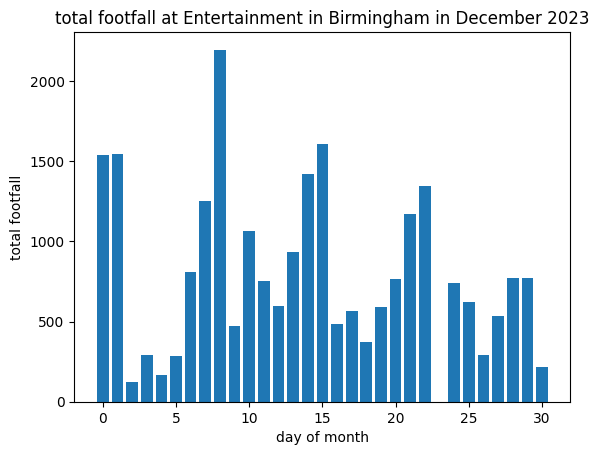

In [ ]:
plot_footfall_by_day(mp,'place_category','Entertainment')